### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000017C18502160>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 5: Machine learning k-fold cross-validation

ASSUMPTION --> run for datasets ESC-10, BDLib2 and US8K:

* *01_Feature_extraction_exploration.ipynb*
* *02_PreProcessing_and_ML_modeling.ipynb* 

And run for the new dataset US8K_AV:
* *03_New_dataset_US8K_AV.ipynb*

After that, run for all datasets:
* *04_ML_modeling.ipynb*

***

## Importe modules

In [2]:
import librosa
import os
import glob
import warnings
import mimetypes
import itertools
import time
import sys

import pandas  as pd
import seaborn as sns
import numpy   as np
from IPython.display import display

from matplotlib  import pyplot as plt

from tqdm                      import tqdm

from sklearn                   import metrics
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.linear_model      import LogisticRegression
from sklearn.naive_bayes       import GaussianNB
from sklearn.svm               import SVC
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import RandomForestClassifier, VotingClassifier
from sklearn.decomposition     import PCA
from sklearn.metrics           import classification_report

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

cmap_cm   = plt.cm.Blues

In [3]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '05_Machine_learning_cross_validation_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

# Loading the dataset


In [4]:
# Select the dataset

opc = 0
while str(opc) not in '1234':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")


    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = '1'

    pkl_features           = 'ESC-10_features_original.pkl'
    pkl_aug_features      = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'

    
if opc == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'

    pkl_features          = 'BDLib2_features_original.pkl'
    pkl_aug_features      = 'BDLib2_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'BDLib2_features_augmented.pkl'

    
if opc == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    
    pkl_features          = 'US8K_features_original.pkl'
    pkl_aug_features      = 'US8K_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    

if opc == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV.csv'
    fold        = '1'

    pkl_features          = 'US8K_AV_features_original.pkl'
    pkl_aug_features      = 'US8K_AV_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_AV_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV

Select the dataset: 4


In [5]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [6]:
from MT_loadDataset import loadDataset

In [7]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
silence              550
car_horn             429
Name: count, dtype: int64

Total number of unique files..........:  4908
Total number of AUDIO files...........:  4908


,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path
0,5,fold5,"[0, 0, 0, 1, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav
1,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav
2,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav
3,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav
4,5,fold5,"[0, 0, 1, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav
...,...,...,...,...,...,...
4903,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_10.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_10.wav
4904,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_11.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_11.wav
4905,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_12.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_12.wav
4906,9,fold9,"[0, 0, 0, 0, 1, 0]",silence,708192_8.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K_AV\Folds\fold9\708192_8.wav


In [8]:
DB.dtypes

Fold                  int64
Folder_name          object
Class_OHEV           object
Class_categorical    object
File_name            object
Path                 object
dtype: object

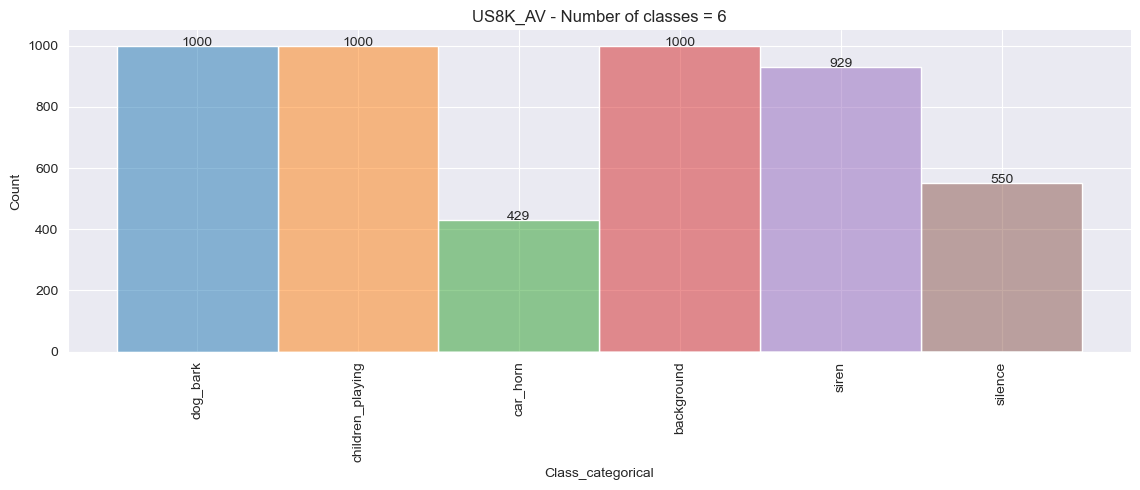

In [9]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [10]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_features))
    model_surname = '_original'

if opc == 2:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_aug_features))
    model_surname = '_augmented'

if opc == 3:
    DB_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))
    model_surname = '_windowed'


1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K only windowed)

Select the dataset: 1


In [11]:
DB_from_pkl.dtypes

Audio                  object
Class_categorical      object
Class_OHEV             object
Fold                   object
RMSE                  float64
                       ...   
TONNETZ_6             float64
TONNETZ_std_6         float64
TONNETZ_median_6      float64
TONNETZ_skew_6        float64
TONNETZ_kurtosis_6    float64
Length: 379, dtype: object

In [12]:
total_duration = 0
for audio in DB_from_pkl['Audio']:
    total_duration = total_duration + librosa.get_duration(y=audio)
print('Total duration of the dataset: ' , "{:0.4f} h".format(total_duration / 3600))

Total duration of the dataset:  5.4533 h


In [13]:
DB_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,...,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,0.121009,...,-0.046785,0.024244,-0.049756,0.759231,-0.024962
1,"[0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...",children_playing,"[0, 0, 1, 0, 0, 0]",5,0.003977,...,-0.017096,0.018670,-0.018241,0.275013,-0.497943
2,"[-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...",children_playing,"[0, 0, 1, 0, 0, 0]",5,0.002999,...,0.007211,0.018733,0.009139,-0.205466,-0.212879
3,"[0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...",children_playing,"[0, 0, 1, 0, 0, 0]",5,0.004600,...,0.003914,0.027117,0.007208,-0.769827,0.623153
4,"[0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...",children_playing,"[0, 0, 1, 0, 0, 0]",5,0.003212,...,0.054360,0.025776,0.050245,0.208739,-1.062755
...,...,...,...,...,...,...,...,...,...,...,...
4903,"[0.0020684754, 0.002996013, 0.0027406309, 0.0031264792, 0.0030979805, 0.0032640784, 0.0030700786, 0.0029712087, 0.00...",silence,"[0, 0, 0, 0, 1, 0]",9,0.002076,...,-0.001692,0.046910,-0.014152,1.014088,0.288518
4904,"[-0.00054763607, -0.0006439837, -0.0003565054, -0.00026786933, -0.00012919167, -0.0002218535, -0.00025803095, -0.000...",silence,"[0, 0, 0, 0, 1, 0]",9,0.002086,...,-0.009712,0.048725,0.003801,-0.290986,-1.009455
4905,"[0.00036112632, 0.0003222265, -2.3932662e-05, -0.00028421593, -0.0005354925, -0.0005733533, -0.00046778092, -0.00020...",silence,"[0, 0, 0, 0, 1, 0]",9,0.002231,...,-0.038786,0.032608,-0.043836,1.350900,2.272794
4906,"[-0.0002325126, -0.00035913184, -0.00025248923, -0.0001690893, 1.3734563e-05, 0.00021053397, 0.0003744613, 0.0003582...",silence,"[0, 0, 0, 0, 1, 0]",9,0.001796,...,-0.006778,0.026508,-0.003402,-0.001074,-0.871445


In [14]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical      
background         3493    [1, 0, 0, 0, 0, 0]
car_horn           1627    [0, 1, 0, 0, 0, 0]
children_playing   1687    [0, 0, 1, 0, 0, 0]
dog_bark           1784    [0, 0, 0, 1, 0, 0]
silence            4389    [0, 0, 0, 0, 1, 0]
siren              440     [0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'background': array([1, 0, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0, 0]),
 'silence': array([0, 0, 0, 0, 1, 0]),
 'siren': array([0, 0, 0, 0, 0, 1])}

In [15]:
nom_classes = list(encoder_dict.keys())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'silence', 'siren']

In [16]:
# with open('columns_mel_featurest.txt.txt', 'r') as file:
#     columnsKeep = [line.strip() for line in file]

In [17]:
# new_df = DB_from_pkl[columnsKeep]

## ML Modeling

In [18]:
def get_mutual_info (X: list, X_val: list, X_norm: list, y: list):
    
    mutual_info = mutual_info_classif(X_norm, y)
    mutual_info = pd.Series(mutual_info)
    
    threshold = np.mean(mutual_info.sort_values(ascending=False))
    print(f' Threshold: {threshold}')
    
    count_mutual = sum(1 for element in mutual_info if element > threshold)
    print(f' Count mutual: {count_mutual}\n')
    
    chi2_selector    = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
    mutual_idx_train = chi2_selector.get_support(1)
    
    X_mutual     = X[X.columns[mutual_idx_train]] # final features
    X_val_mutual = X_val[X_val.columns[mutual_idx_train]] # final features

    print(f'X_train_mutual...: {X_mutual.shape}')
    print(f'X_val_mutual.....: {X_val_mutual.shape}\n')

    return X_mutual, X_val_mutual

In [19]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.tight_layout()

In [20]:
# Pipeline to run the classifiers and their metrics using k-fold stratification according to the dataset specification

def model_classifiers(db: pd.DataFrame, 
                      scalerOpt: str, 
                      use_PCA = False,
                      use_mutual = False):
    
    if use_PCA:
        p = 2
    else:
        p = 1
    
    classifiers = ['Naïve Bayes', 'SVC', 'LogisticR', 'KNN', 'Forest', 'Voting']
    
    
    NB_c          = GaussianNB()
    SVC_c         = SVC(kernel = 'linear', C = 0.5, probability = True, random_state = SEED)
    LogisticR_c   = LogisticRegression(solver = 'saga', max_iter = 500, C = 0.5, n_jobs = -1)
    KNN_c         = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = p, leaf_size = 20, n_jobs = -1)
    forest_c      = RandomForestClassifier(n_estimators = 500, criterion = 'gini',bootstrap = True, n_jobs = -1)
    voting_c      = VotingClassifier(estimators = [(classifiers[0], NB_c),
                                                   (classifiers[1], SVC_c),
                                                   (classifiers[2], LogisticR_c),
                                                   (classifiers[3], KNN_c)],
                                     voting = 'soft')
    
    dic_classifiers = {'GaussianNB': NB_c, 
                       'SVC': SVC_c, 
                       'LogisticR' : LogisticR_c, 
                       'KNN': KNN_c, 
                       'Forest': forest_c, 
                       'Voting': voting_c}

    count       = 1
    ratio       = []
    models      = []
    acc_set     = pd.DataFrame(index=None, columns=['Model',
                                                    'Fold',
                                                    'Accuracy(Train)',
                                                    'Accuracy(Validation)',
                                                    'F1(Train)',
                                                    'F1(Validation)', 
                                                    'Precision(Train)',
                                                    'Precision(Validation)', 
                                                    'Recall(Train)',
                                                    'Recall(Validation)', 
                                                    'Conf_M',
                                                    'Process_time'])
    
    for fold in np.unique(db['Fold']):
        print(f"Validation fold: {fold}")
    
        DB_VAL = db[db['Fold'] == fold]
        DB_TRN = db[db['Fold'] != fold]
        
        X      = DB_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y      = np.array(DB_TRN.Class_categorical.to_list())
        y_OHEV = np.array(DB_TRN.Class_OHEV.to_list())

        X_val      = DB_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y_val      = np.array(DB_VAL.Class_categorical.to_list())
        y_OHEV_val = np.array(DB_VAL.Class_OHEV.to_list())

        X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

        X_mean   = X_statistics.values[:, 0]
        X_std    = X_statistics.values[:, 1]
        X_min    = X_statistics.values[:, 2]
        X_max    = X_statistics.values[:, 3]
        
        if scalerOpt == "normalization":
            X_train_norm = (X.values - X_min) / (X_max - X_min)
            X_val_norm   = (X_val.values - X_min) / (X_max - X_min)
            batch_type    = '_norm'
            print(f'X_train_norm shape...:{X_train_norm.shape}')
            print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
        elif scalerOpt == "standardization":
            X_train_norm = (X.values - X_mean) / X_std
            X_val_norm   = (X_val.values - X_mean) / X_std
            batch_type    = '_std'
            print(f'X_train_norm shape...:{X_train_norm.shape}')
            print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
        else:
            sys.exit()
            
        if use_mutual:
            if scalerOpt == "standardization":
                print(f'Mutual information requires normalization!')
                sys.exit()
            else:
                X_train_norm, X_val_norm = get_mutual_info(X, X_val, X_train_norm, y)
                classifiers = ['Forest']
                dic_classifiers = {'Forest': forest_c}
                batch_type    = batch_type + '_mutual'
   
        if use_PCA:
            pcaT = PCA()
            pcaT.fit(X_train_norm)
            ratio = pcaT.explained_variance_ratio_
            
            batch_type = batch_type + '_PCA'
            
            T           = 0.98
            current_sum = 0
            countComp   = 0

            for element in ratio:
                current_sum += element
                countComp   += 1

                if current_sum >= T:
                    break

            # Print the result
            print(f'Sum of elements............: {current_sum}')
            print(f'Number of elements summed..: {countComp}\n')           
            
            pca          = PCA(n_components = countComp)
            X_train_norm = pca.fit_transform(X_train_norm)
            X_val_norm   = pca.transform(X_val_norm)
            
       
        for c in tqdm(dic_classifiers.items()):
            
            name         = c[0]
            model_name   = ('Model_' + c[0] + '_' + str(count))
            count        = count + 1
            model        = c[1]
            print(name)
            print(model)
            print(X_train_norm.shape)
            
            # Fitting the model to the classifier
            model.fit(X_train_norm, y)

            # Get the model predictions
            y_train_predicted = model.predict(X_train_norm)
            
            t_srt             = time.process_time_ns()
            y_val_predicited  = model.predict(X_val_norm)
            t_end             = time.process_time_ns()
            proc_time         = ((t_end - t_srt) / 1000000)

            # Compute the classifier metrics
            accuracy_train = metrics.accuracy_score(y, y_train_predicted)
            accuracy_val   = metrics.accuracy_score(y_val,  y_val_predicited)
            
            f1_Score_train = metrics.f1_score(y, y_train_predicted, average = 'weighted')
            f1_Score_val   = metrics.f1_score(y_val,  y_val_predicited, average = 'weighted')

            precision_score_train = metrics.precision_score(y, y_train_predicted, average = 'weighted')
            precision_score_val   = metrics.precision_score(y_val,  y_val_predicited, average = 'weighted')

            recall_score_train = metrics.recall_score(y, y_train_predicted, average = 'weighted')
            recall_score_val   = metrics.recall_score(y_val,  y_val_predicited, average = 'weighted')

            class_report_val = classification_report(y_val, y_val_predicited)
            print(class_report_val)
            
            # Compute the confusion matrix
            CM = metrics.confusion_matrix(y_val, y_val_predicited)

            # Store the name, validation accuracy results and model
            models.append((name, accuracy_val, model))
            
            del model
                    
            acc_set = pd.concat([acc_set, pd.DataFrame({'Model': [name],
                                                        'Fold': [fold],
                                                        'Accuracy(Train)': [accuracy_train],
                                                        'Accuracy(Validation)': [accuracy_val],
                                                        'F1(Train)': [f1_Score_train],
                                                        'F1(Validation)': [f1_Score_val],
                                                        'Precision(Train)': [precision_score_train],
                                                        'Precision(Validation)': [precision_score_val],
                                                        'Recall(Train)': [recall_score_train],
                                                        'Recall(Validation)': [recall_score_val],
                                                        'Conf_M': [CM],
                                                        'Process_time': [proc_time]})], ignore_index = True)
                   
    return acc_set, models, ratio, batch_type

In [22]:
# Option for scalerOpt is either "normalization" or "standardization"

# PCA with mutual is ilogical, results will be useless
# Mutual does not work with negative numbers, therefore "standardization" returns an error
# Mutual will trigger only Random Forest

metrics_set, models_set,  ratio, batch_name = model_classifiers(DB_from_pkl,
                                                                scalerOpt = 'normalization',
                                                                use_PCA = False,
                                                                use_mutual = False)

Validation fold: 1
X_train_norm shape...:(4430, 375)
X_val_norm shape.....:(478, 375)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(4430, 375)


 17%|██████████████                                                                      | 1/6 [00:00<00:01,  4.49it/s]

                  precision    recall  f1-score   support

      background       0.77      0.34      0.47       108
        car_horn       0.62      0.69      0.66        36
children_playing       0.45      0.82      0.58       100
        dog_bark       0.65      0.28      0.39       100
         silence       0.57      0.98      0.72        48
           siren       0.65      0.60      0.63        86

        accuracy                           0.57       478
       macro avg       0.62      0.62      0.57       478
    weighted avg       0.62      0.57      0.54       478

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(4430, 375)


 33%|████████████████████████████                                                        | 2/6 [00:05<00:12,  3.20s/it]

                  precision    recall  f1-score   support

      background       0.94      0.88      0.91       108
        car_horn       0.83      0.94      0.88        36
children_playing       0.76      0.89      0.82       100
        dog_bark       0.98      0.85      0.91       100
         silence       0.82      0.98      0.90        48
           siren       0.91      0.79      0.84        86

        accuracy                           0.87       478
       macro avg       0.87      0.89      0.88       478
    weighted avg       0.88      0.87      0.88       478

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(4430, 375)


 50%|██████████████████████████████████████████                                          | 3/6 [00:13<00:15,  5.24s/it]

                  precision    recall  f1-score   support

      background       0.92      0.86      0.89       108
        car_horn       0.83      0.97      0.90        36
children_playing       0.78      0.87      0.82       100
        dog_bark       0.97      0.87      0.92       100
         silence       0.81      0.98      0.89        48
           siren       0.89      0.79      0.84        86

        accuracy                           0.87       478
       macro avg       0.87      0.89      0.88       478
    weighted avg       0.88      0.87      0.87       478

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3, p=1)
(4430, 375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:15<00:08,  4.17s/it]

                  precision    recall  f1-score   support

      background       0.92      0.71      0.80       108
        car_horn       0.76      0.89      0.82        36
children_playing       0.61      0.94      0.74       100
        dog_bark       0.94      0.63      0.75       100
         silence       0.81      0.98      0.89        48
           siren       0.86      0.73      0.79        86

        accuracy                           0.79       478
       macro avg       0.82      0.81      0.80       478
    weighted avg       0.83      0.79      0.79       478

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(4430, 375)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:29<00:07,  7.75s/it]

                  precision    recall  f1-score   support

      background       0.85      0.75      0.80       108
        car_horn       0.83      0.83      0.83        36
children_playing       0.82      0.89      0.85       100
        dog_bark       0.90      0.84      0.87       100
         silence       0.70      0.98      0.82        48
           siren       0.94      0.85      0.89        86

        accuracy                           0.85       478
       macro avg       0.84      0.86      0.84       478
    weighted avg       0.85      0.85      0.85       478

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='s

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.84s/it]


                  precision    recall  f1-score   support

      background       0.95      0.80      0.86       108
        car_horn       0.82      0.89      0.85        36
children_playing       0.69      0.92      0.79       100
        dog_bark       0.96      0.73      0.83       100
         silence       0.75      0.98      0.85        48
           siren       0.91      0.79      0.84        86

        accuracy                           0.83       478
       macro avg       0.84      0.85      0.84       478
    weighted avg       0.86      0.83      0.83       478

Validation fold: 10
X_train_norm shape...:(4440, 375)
X_val_norm shape.....:(468, 375)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(4440, 375)


 17%|██████████████                                                                      | 1/6 [00:00<00:00,  5.44it/s]

                  precision    recall  f1-score   support

      background       0.90      0.35      0.50       103
        car_horn       0.76      0.48      0.59        33
children_playing       0.35      0.69      0.46       100
        dog_bark       0.67      0.35      0.46       100
         silence       0.49      1.00      0.66        49
           siren       0.28      0.19      0.23        83

        accuracy                           0.47       468
       macro avg       0.58      0.51      0.48       468
    weighted avg       0.57      0.47      0.46       468

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(4440, 375)


 33%|████████████████████████████                                                        | 2/6 [00:04<00:10,  2.72s/it]

                  precision    recall  f1-score   support

      background       0.86      0.92      0.89       103
        car_horn       0.86      0.73      0.79        33
children_playing       0.63      0.95      0.76       100
        dog_bark       0.90      0.72      0.80       100
         silence       0.92      0.94      0.93        49
           siren       0.92      0.55      0.69        83

        accuracy                           0.81       468
       macro avg       0.85      0.80      0.81       468
    weighted avg       0.84      0.81      0.81       468

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(4440, 375)


 50%|██████████████████████████████████████████                                          | 3/6 [00:17<00:21,  7.29s/it]

                  precision    recall  f1-score   support

      background       0.89      0.88      0.89       103
        car_horn       0.83      0.76      0.79        33
children_playing       0.64      0.95      0.76       100
        dog_bark       0.91      0.73      0.81       100
         silence       0.92      1.00      0.96        49
           siren       0.85      0.55      0.67        83

        accuracy                           0.81       468
       macro avg       0.84      0.81      0.81       468
    weighted avg       0.83      0.81      0.81       468

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3, p=1)
(4440, 375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:19<00:10,  5.18s/it]

                  precision    recall  f1-score   support

      background       0.89      0.71      0.79       103
        car_horn       0.88      0.67      0.76        33
children_playing       0.44      0.92      0.60       100
        dog_bark       0.96      0.53      0.68       100
         silence       0.76      0.78      0.77        49
           siren       0.88      0.51      0.64        83

        accuracy                           0.68       468
       macro avg       0.80      0.68      0.71       468
    weighted avg       0.79      0.68      0.70       468

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(4440, 375)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:35<00:09,  9.10s/it]

                  precision    recall  f1-score   support

      background       0.87      0.90      0.89       103
        car_horn       1.00      0.73      0.84        33
children_playing       0.61      0.88      0.72       100
        dog_bark       0.95      0.75      0.84       100
         silence       0.80      1.00      0.89        49
           siren       0.81      0.51      0.62        83

        accuracy                           0.79       468
       macro avg       0.84      0.79      0.80       468
    weighted avg       0.82      0.79      0.79       468

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='s

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.31s/it]


                  precision    recall  f1-score   support

      background       0.92      0.79      0.85       103
        car_horn       0.95      0.64      0.76        33
children_playing       0.53      0.93      0.67       100
        dog_bark       0.94      0.65      0.77       100
         silence       0.80      1.00      0.89        49
           siren       0.83      0.52      0.64        83

        accuracy                           0.75       468
       macro avg       0.83      0.75      0.76       468
    weighted avg       0.81      0.75      0.76       468

Validation fold: 2
X_train_norm shape...:(4423, 375)
X_val_norm shape.....:(485, 375)



 17%|██████████████                                                                      | 1/6 [00:00<00:00,  5.22it/s]

GaussianNB
GaussianNB()
(4423, 375)
                  precision    recall  f1-score   support

      background       0.96      0.24      0.38        96
        car_horn       0.47      0.17      0.25        42
children_playing       0.40      0.93      0.56       100
        dog_bark       0.76      0.29      0.42       100
         silence       0.60      1.00      0.75        56
           siren       0.43      0.40      0.41        91

        accuracy                           0.50       485
       macro avg       0.60      0.50      0.46       485
    weighted avg       0.62      0.50      0.46       485

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(4423, 375)


 33%|████████████████████████████                                                        | 2/6 [00:04<00:11,  2.90s/it]

                  precision    recall  f1-score   support

      background       0.64      0.79      0.71        96
        car_horn       0.81      0.50      0.62        42
children_playing       0.76      0.91      0.83       100
        dog_bark       0.96      0.87      0.91       100
         silence       0.93      1.00      0.97        56
           siren       0.93      0.70      0.80        91

        accuracy                           0.81       485
       macro avg       0.84      0.80      0.80       485
    weighted avg       0.83      0.81      0.81       485

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(4423, 375)


 50%|██████████████████████████████████████████                                          | 3/6 [00:14<00:18,  6.03s/it]

                  precision    recall  f1-score   support

      background       0.66      0.74      0.70        96
        car_horn       0.80      0.48      0.60        42
children_playing       0.73      0.91      0.81       100
        dog_bark       0.91      0.87      0.89       100
         silence       0.88      1.00      0.93        56
           siren       0.97      0.71      0.82        91

        accuracy                           0.80       485
       macro avg       0.82      0.79      0.79       485
    weighted avg       0.82      0.80      0.80       485

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3, p=1)
(4423, 375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:16<00:08,  4.48s/it]

                  precision    recall  f1-score   support

      background       0.61      0.45      0.52        96
        car_horn       0.70      0.67      0.68        42
children_playing       0.53      0.94      0.68       100
        dog_bark       0.96      0.65      0.77       100
         silence       0.82      0.96      0.89        56
           siren       0.77      0.54      0.63        91

        accuracy                           0.69       485
       macro avg       0.73      0.70      0.70       485
    weighted avg       0.73      0.69      0.68       485

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(4423, 375)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:33<00:08,  8.70s/it]

                  precision    recall  f1-score   support

      background       0.74      0.83      0.78        96
        car_horn       0.81      0.50      0.62        42
children_playing       0.71      0.95      0.81       100
        dog_bark       0.91      0.92      0.92       100
         silence       0.93      0.98      0.96        56
           siren       0.91      0.57      0.70        91

        accuracy                           0.81       485
       macro avg       0.84      0.79      0.80       485
    weighted avg       0.83      0.81      0.81       485

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='s

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:50<00:00,  8.45s/it]


                  precision    recall  f1-score   support

      background       0.73      0.48      0.58        96
        car_horn       0.69      0.52      0.59        42
children_playing       0.54      0.97      0.69       100
        dog_bark       0.96      0.80      0.87       100
         silence       0.88      1.00      0.93        56
           siren       0.87      0.60      0.71        91

        accuracy                           0.73       485
       macro avg       0.78      0.73      0.73       485
    weighted avg       0.78      0.73      0.73       485

Validation fold: 3
X_train_norm shape...:(4372, 375)
X_val_norm shape.....:(536, 375)



 17%|██████████████                                                                      | 1/6 [00:00<00:00,  5.33it/s]

GaussianNB
GaussianNB()
(4372, 375)
                  precision    recall  f1-score   support

      background       0.88      0.36      0.51       120
        car_horn       0.88      0.81      0.84        43
children_playing       0.38      0.89      0.53       100
        dog_bark       0.40      0.25      0.31       100
         silence       0.88      0.98      0.93        54
           siren       0.53      0.41      0.46       119

        accuracy                           0.55       536
       macro avg       0.66      0.62      0.60       536
    weighted avg       0.62      0.55      0.54       536

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(4372, 375)


 33%|████████████████████████████                                                        | 2/6 [00:04<00:10,  2.74s/it]

                  precision    recall  f1-score   support

      background       0.79      0.89      0.84       120
        car_horn       0.91      1.00      0.96        43
children_playing       0.70      0.92      0.79       100
        dog_bark       0.94      0.76      0.84       100
         silence       1.00      0.70      0.83        54
           siren       0.92      0.80      0.86       119

        accuracy                           0.84       536
       macro avg       0.88      0.85      0.85       536
    weighted avg       0.86      0.84      0.84       536

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(4372, 375)


 50%|██████████████████████████████████████████                                          | 3/6 [00:14<00:17,  5.95s/it]

                  precision    recall  f1-score   support

      background       0.83      0.88      0.86       120
        car_horn       0.88      1.00      0.93        43
children_playing       0.66      0.89      0.76       100
        dog_bark       0.93      0.75      0.83       100
         silence       1.00      0.67      0.80        54
           siren       0.91      0.83      0.87       119

        accuracy                           0.84       536
       macro avg       0.87      0.84      0.84       536
    weighted avg       0.86      0.84      0.84       536

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3, p=1)
(4372, 375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:16<00:08,  4.38s/it]

                  precision    recall  f1-score   support

      background       0.74      0.58      0.65       120
        car_horn       0.86      0.98      0.91        43
children_playing       0.53      0.95      0.68       100
        dog_bark       0.96      0.48      0.64       100
         silence       0.65      0.59      0.62        54
           siren       0.83      0.81      0.82       119

        accuracy                           0.71       536
       macro avg       0.76      0.73      0.72       536
    weighted avg       0.76      0.71      0.71       536

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(4372, 375)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:32<00:08,  8.50s/it]

                  precision    recall  f1-score   support

      background       0.68      0.90      0.78       120
        car_horn       0.90      1.00      0.95        43
children_playing       0.76      0.90      0.83       100
        dog_bark       0.95      0.75      0.84       100
         silence       0.98      0.78      0.87        54
           siren       0.90      0.68      0.78       119

        accuracy                           0.82       536
       macro avg       0.86      0.83      0.84       536
    weighted avg       0.84      0.82      0.82       536

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='s

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:50<00:00,  8.38s/it]


                  precision    recall  f1-score   support

      background       0.92      0.78      0.85       120
        car_horn       0.96      1.00      0.98        43
children_playing       0.59      0.96      0.73       100
        dog_bark       0.97      0.64      0.77       100
         silence       0.98      0.83      0.90        54
           siren       0.91      0.88      0.90       119

        accuracy                           0.83       536
       macro avg       0.89      0.85      0.85       536
    weighted avg       0.88      0.83      0.84       536

Validation fold: 4
X_train_norm shape...:(4309, 375)
X_val_norm shape.....:(599, 375)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(4309, 375)


 17%|██████████████                                                                      | 1/6 [00:00<00:00,  5.83it/s]

                  precision    recall  f1-score   support

      background       0.76      0.39      0.52       114
        car_horn       0.68      0.29      0.40        59
children_playing       0.28      0.72      0.41       100
        dog_bark       0.63      0.38      0.48       100
         silence       0.80      0.95      0.87        60
           siren       0.65      0.51      0.57       166

        accuracy                           0.52       599
       macro avg       0.64      0.54      0.54       599
    weighted avg       0.63      0.52      0.53       599

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(4309, 375)


 33%|████████████████████████████                                                        | 2/6 [00:04<00:10,  2.63s/it]

                  precision    recall  f1-score   support

      background       0.67      0.83      0.75       114
        car_horn       0.92      0.59      0.72        59
children_playing       0.73      0.73      0.73       100
        dog_bark       0.80      0.78      0.79       100
         silence       0.92      0.90      0.91        60
           siren       0.94      0.93      0.93       166

        accuracy                           0.82       599
       macro avg       0.83      0.79      0.80       599
    weighted avg       0.83      0.82      0.82       599

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(4309, 375)


 50%|██████████████████████████████████████████                                          | 3/6 [00:13<00:16,  5.56s/it]

                  precision    recall  f1-score   support

      background       0.66      0.85      0.74       114
        car_horn       0.88      0.49      0.63        59
children_playing       0.82      0.75      0.78       100
        dog_bark       0.80      0.84      0.82       100
         silence       0.93      0.88      0.91        60
           siren       0.93      0.92      0.92       166

        accuracy                           0.82       599
       macro avg       0.84      0.79      0.80       599
    weighted avg       0.83      0.82      0.82       599

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3, p=1)
(4309, 375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:15<00:08,  4.14s/it]

                  precision    recall  f1-score   support

      background       0.79      0.68      0.73       114
        car_horn       0.96      0.46      0.62        59
children_playing       0.47      0.88      0.61       100
        dog_bark       0.68      0.60      0.64       100
         silence       0.82      0.68      0.75        60
           siren       0.84      0.74      0.79       166

        accuracy                           0.69       599
       macro avg       0.76      0.67      0.69       599
    weighted avg       0.75      0.69      0.70       599

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(4309, 375)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:32<00:08,  8.63s/it]

                  precision    recall  f1-score   support

      background       0.62      0.83      0.71       114
        car_horn       1.00      0.46      0.63        59
children_playing       0.70      0.70      0.70       100
        dog_bark       0.75      0.85      0.80       100
         silence       0.88      0.82      0.84        60
           siren       0.95      0.85      0.90       166

        accuracy                           0.78       599
       macro avg       0.82      0.75      0.76       599
    weighted avg       0.81      0.78      0.78       599

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='s

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:52<00:00,  8.75s/it]


                  precision    recall  f1-score   support

      background       0.80      0.74      0.77       114
        car_horn       0.97      0.53      0.68        59
children_playing       0.55      0.83      0.66       100
        dog_bark       0.82      0.73      0.77       100
         silence       0.90      0.95      0.93        60
           siren       0.91      0.87      0.89       166

        accuracy                           0.79       599
       macro avg       0.83      0.77      0.78       599
    weighted avg       0.82      0.79      0.79       599

Validation fold: 5
X_train_norm shape...:(4379, 375)
X_val_norm shape.....:(529, 375)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(4379, 375)
                  precision    recall  f1-score   support

      background       0.57      0.45      0.51        99
        car_horn       0.85      0.22      0.35        98
children_playing       0.37      0.62      0.46       100
        dog_bark       0.60      0.42      0.49       100
         silence       0.66      1.00      0.80        61
           siren       0.66      0.87      0.75        71

        accuracy                           0.56       529
       macro avg       0.62      0.60      0.56       529
    weighted avg       0.61      0.56      0.53       529



 17%|██████████████                                                                      | 1/6 [00:00<00:00,  5.17it/s]

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(4379, 375)


 33%|████████████████████████████                                                        | 2/6 [00:05<00:12,  3.22s/it]

                  precision    recall  f1-score   support

      background       0.66      0.90      0.76        99
        car_horn       0.94      0.60      0.73        98
children_playing       0.76      0.82      0.79       100
        dog_bark       0.81      0.70      0.75       100
         silence       0.97      0.98      0.98        61
           siren       0.84      0.90      0.87        71

        accuracy                           0.80       529
       macro avg       0.83      0.82      0.81       529
    weighted avg       0.82      0.80      0.80       529

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(4379, 375)


 50%|██████████████████████████████████████████                                          | 3/6 [00:14<00:17,  5.69s/it]

                  precision    recall  f1-score   support

      background       0.62      0.86      0.72        99
        car_horn       0.93      0.54      0.68        98
children_playing       0.76      0.81      0.79       100
        dog_bark       0.80      0.72      0.76       100
         silence       0.95      0.98      0.97        61
           siren       0.83      0.89      0.86        71

        accuracy                           0.78       529
       macro avg       0.82      0.80      0.80       529
    weighted avg       0.81      0.78      0.78       529

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3, p=1)
(4379, 375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:16<00:08,  4.23s/it]

                  precision    recall  f1-score   support

      background       0.78      0.74      0.76        99
        car_horn       0.94      0.69      0.80        98
children_playing       0.56      0.94      0.70       100
        dog_bark       0.96      0.52      0.68       100
         silence       0.85      0.98      0.91        61
           siren       0.87      0.86      0.87        71

        accuracy                           0.77       529
       macro avg       0.83      0.79      0.78       529
    weighted avg       0.82      0.77      0.77       529

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(4379, 375)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:32<00:08,  8.71s/it]

                  precision    recall  f1-score   support

      background       0.56      0.90      0.69        99
        car_horn       0.97      0.59      0.73        98
children_playing       0.81      0.79      0.80       100
        dog_bark       0.87      0.77      0.81       100
         silence       0.95      0.98      0.97        61
           siren       0.95      0.83      0.89        71

        accuracy                           0.80       529
       macro avg       0.85      0.81      0.82       529
    weighted avg       0.84      0.80      0.80       529

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='s

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:50<00:00,  8.42s/it]


                  precision    recall  f1-score   support

      background       0.69      0.78      0.73        99
        car_horn       0.97      0.63      0.77        98
children_playing       0.62      0.93      0.75       100
        dog_bark       0.87      0.59      0.70       100
         silence       0.90      0.98      0.94        61
           siren       0.91      0.90      0.91        71

        accuracy                           0.78       529
       macro avg       0.83      0.80      0.80       529
    weighted avg       0.82      0.78      0.78       529

Validation fold: 6
X_train_norm shape...:(4448, 375)
X_val_norm shape.....:(460, 375)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(4448, 375)
                  precision    recall  f1-score   support

      background       0.72      0.35      0.47        98
        car_horn       0.89      0.57      0.70        28
children_playing       0.38      0.72      0.50       100
        dog_bark       0.64      0.28      0.39       100
         silence       0.65      1.00      0.79        60
           siren       0.66      0.64      0.65        74

        accuracy                           0.56       460
       macro avg       0.66      0.59      0.58       460
    weighted avg       0.62      0.56      0.54       460



 17%|██████████████                                                                      | 1/6 [00:00<00:01,  4.96it/s]

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(4448, 375)


 33%|████████████████████████████                                                        | 2/6 [00:05<00:13,  3.42s/it]

                  precision    recall  f1-score   support

      background       0.76      0.84      0.80        98
        car_horn       0.86      0.86      0.86        28
children_playing       0.79      0.89      0.84       100
        dog_bark       0.89      0.80      0.84       100
         silence       0.95      1.00      0.98        60
           siren       0.92      0.73      0.81        74

        accuracy                           0.85       460
       macro avg       0.86      0.85      0.85       460
    weighted avg       0.85      0.85      0.85       460

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(4448, 375)


 50%|██████████████████████████████████████████                                          | 3/6 [00:15<00:18,  6.09s/it]

                  precision    recall  f1-score   support

      background       0.78      0.88      0.83        98
        car_horn       0.85      0.82      0.84        28
children_playing       0.80      0.90      0.85       100
        dog_bark       0.91      0.80      0.85       100
         silence       0.94      1.00      0.97        60
           siren       0.93      0.74      0.83        74

        accuracy                           0.86       460
       macro avg       0.87      0.86      0.86       460
    weighted avg       0.86      0.86      0.86       460

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3, p=1)
(4448, 375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:17<00:09,  4.50s/it]

                  precision    recall  f1-score   support

      background       0.88      0.62      0.73        98
        car_horn       0.79      0.82      0.81        28
children_playing       0.56      0.94      0.70       100
        dog_bark       0.92      0.56      0.70       100
         silence       0.69      0.73      0.71        60
           siren       0.79      0.73      0.76        74

        accuracy                           0.72       460
       macro avg       0.77      0.73      0.73       460
    weighted avg       0.77      0.72      0.72       460

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(4448, 375)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:34<00:08,  8.96s/it]

                  precision    recall  f1-score   support

      background       0.72      0.88      0.79        98
        car_horn       0.96      0.79      0.86        28
children_playing       0.78      0.84      0.81       100
        dog_bark       0.87      0.77      0.81       100
         silence       0.88      1.00      0.94        60
           siren       0.96      0.68      0.79        74

        accuracy                           0.82       460
       macro avg       0.86      0.82      0.83       460
    weighted avg       0.84      0.82      0.82       460

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='s

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.05s/it]


                  precision    recall  f1-score   support

      background       0.93      0.81      0.86        98
        car_horn       0.92      0.82      0.87        28
children_playing       0.61      0.92      0.74       100
        dog_bark       0.90      0.66      0.76       100
         silence       0.92      1.00      0.96        60
           siren       0.97      0.81      0.88        74

        accuracy                           0.83       460
       macro avg       0.88      0.84      0.85       460
    weighted avg       0.86      0.83      0.83       460

Validation fold: 7
X_train_norm shape...:(4443, 375)
X_val_norm shape.....:(465, 375)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(4443, 375)


 17%|██████████████                                                                      | 1/6 [00:00<00:00,  5.36it/s]

                  precision    recall  f1-score   support

      background       0.91      0.31      0.46       100
        car_horn       0.67      0.29      0.40        28
children_playing       0.37      0.86      0.52       100
        dog_bark       0.62      0.31      0.41       100
         silence       0.76      1.00      0.86        60
           siren       0.47      0.36      0.41        77

        accuracy                           0.52       465
       macro avg       0.63      0.52      0.51       465
    weighted avg       0.63      0.52      0.50       465

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(4443, 375)


 33%|████████████████████████████                                                        | 2/6 [00:05<00:13,  3.38s/it]

                  precision    recall  f1-score   support

      background       0.78      0.73      0.76       100
        car_horn       0.96      0.86      0.91        28
children_playing       0.76      0.85      0.80       100
        dog_bark       0.82      0.90      0.86       100
         silence       1.00      0.85      0.92        60
           siren       0.86      0.83      0.85        77

        accuracy                           0.83       465
       macro avg       0.86      0.84      0.85       465
    weighted avg       0.84      0.83      0.83       465

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(4443, 375)


 50%|██████████████████████████████████████████                                          | 3/6 [00:18<00:22,  7.48s/it]

                  precision    recall  f1-score   support

      background       0.69      0.74      0.71       100
        car_horn       0.92      0.79      0.85        28
children_playing       0.79      0.78      0.78       100
        dog_bark       0.80      0.90      0.85       100
         silence       0.92      0.95      0.93        60
           siren       0.88      0.68      0.76        77

        accuracy                           0.80       465
       macro avg       0.83      0.81      0.81       465
    weighted avg       0.81      0.80      0.80       465

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3, p=1)
(4443, 375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:20<00:10,  5.41s/it]

                  precision    recall  f1-score   support

      background       0.62      0.50      0.55       100
        car_horn       0.67      0.57      0.62        28
children_playing       0.48      0.81      0.60       100
        dog_bark       0.94      0.68      0.79       100
         silence       0.78      0.75      0.76        60
           siren       0.53      0.43      0.47        77

        accuracy                           0.63       465
       macro avg       0.67      0.62      0.63       465
    weighted avg       0.67      0.63      0.63       465

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(4443, 375)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:37<00:09,  9.57s/it]

                  precision    recall  f1-score   support

      background       0.65      0.81      0.72       100
        car_horn       0.94      0.61      0.74        28
children_playing       0.71      0.80      0.75       100
        dog_bark       0.90      0.88      0.89       100
         silence       0.93      0.93      0.93        60
           siren       0.77      0.52      0.62        77

        accuracy                           0.78       465
       macro avg       0.82      0.76      0.78       465
    weighted avg       0.79      0.78      0.78       465

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='s

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it]


                  precision    recall  f1-score   support

      background       0.77      0.63      0.69       100
        car_horn       0.95      0.64      0.77        28
children_playing       0.62      0.89      0.73       100
        dog_bark       0.88      0.83      0.86       100
         silence       0.86      0.98      0.91        60
           siren       0.82      0.61      0.70        77

        accuracy                           0.77       465
       macro avg       0.82      0.76      0.78       465
    weighted avg       0.79      0.77      0.77       465

Validation fold: 8
X_train_norm shape...:(4467, 375)
X_val_norm shape.....:(441, 375)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(4467, 375)


 17%|██████████████                                                                      | 1/6 [00:00<00:00,  5.60it/s]

                  precision    recall  f1-score   support

      background       0.63      0.34      0.44        80
        car_horn       0.92      0.80      0.86        30
children_playing       0.39      0.56      0.46       100
        dog_bark       0.69      0.27      0.39       100
         silence       0.50      1.00      0.66        51
           siren       0.51      0.56      0.54        80

        accuracy                           0.52       441
       macro avg       0.61      0.59      0.56       441
    weighted avg       0.57      0.52      0.50       441

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(4467, 375)


 33%|████████████████████████████                                                        | 2/6 [00:05<00:13,  3.44s/it]

                  precision    recall  f1-score   support

      background       0.77      0.84      0.80        80
        car_horn       0.76      0.97      0.85        30
children_playing       0.83      0.81      0.82       100
        dog_bark       0.98      0.80      0.88       100
         silence       0.88      1.00      0.94        51
           siren       0.85      0.82      0.84        80

        accuracy                           0.85       441
       macro avg       0.84      0.87      0.85       441
    weighted avg       0.86      0.85      0.85       441

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(4467, 375)


 50%|██████████████████████████████████████████                                          | 3/6 [00:16<00:19,  6.51s/it]

                  precision    recall  f1-score   support

      background       0.60      0.89      0.71        80
        car_horn       0.86      1.00      0.92        30
children_playing       0.89      0.79      0.84       100
        dog_bark       0.98      0.83      0.90       100
         silence       0.88      1.00      0.94        51
           siren       0.76      0.53      0.62        80

        accuracy                           0.81       441
       macro avg       0.83      0.84      0.82       441
    weighted avg       0.83      0.81      0.81       441

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3, p=1)
(4467, 375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:18<00:09,  4.80s/it]

                  precision    recall  f1-score   support

      background       0.55      0.60      0.57        80
        car_horn       0.89      0.80      0.84        30
children_playing       0.55      0.86      0.67       100
        dog_bark       0.98      0.52      0.68       100
         silence       0.76      0.94      0.84        51
           siren       0.68      0.45      0.54        80

        accuracy                           0.67       441
       macro avg       0.73      0.70      0.69       441
    weighted avg       0.72      0.67      0.66       441

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(4467, 375)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:36<00:09,  9.70s/it]

                  precision    recall  f1-score   support

      background       0.53      0.90      0.66        80
        car_horn       1.00      0.93      0.97        30
children_playing       0.84      0.71      0.77       100
        dog_bark       0.93      0.78      0.85       100
         silence       0.80      1.00      0.89        51
           siren       0.88      0.47      0.62        80

        accuracy                           0.77       441
       macro avg       0.83      0.80      0.79       441
    weighted avg       0.82      0.77      0.77       441

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='s

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:52<00:00,  8.75s/it]


                  precision    recall  f1-score   support

      background       0.81      0.75      0.78        80
        car_horn       0.88      0.93      0.90        30
children_playing       0.66      0.79      0.72       100
        dog_bark       1.00      0.63      0.77       100
         silence       0.76      1.00      0.86        51
           siren       0.75      0.80      0.78        80

        accuracy                           0.78       441
       macro avg       0.81      0.82      0.80       441
    weighted avg       0.81      0.78      0.78       441

Validation fold: 9
X_train_norm shape...:(4461, 375)
X_val_norm shape.....:(447, 375)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(4461, 375)
                  precision    recall  f1-score   support

      background       0.87      0.49      0.62        82
        car_horn       0.96      0.72      0.82        32
children_playing       0.47      0.79      0.59       100
        dog_bark       0.90      0.26      0.40       100
         silence       0.56      0.98      0.71        51
           siren       0.59      0.66      0.62        82

        accuracy                           0.61       447
       macro avg       0.72      0.65      0.63       447
    weighted avg       0.71      0.61      0.59       447



 17%|██████████████                                                                      | 1/6 [00:00<00:00,  5.57it/s]

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(4461, 375)


 33%|████████████████████████████                                                        | 2/6 [00:04<00:11,  2.80s/it]

                  precision    recall  f1-score   support

      background       0.78      0.83      0.80        82
        car_horn       0.94      0.97      0.95        32
children_playing       0.79      0.88      0.83       100
        dog_bark       0.86      0.63      0.73       100
         silence       0.95      0.82      0.88        51
           siren       0.81      0.98      0.88        82

        accuracy                           0.83       447
       macro avg       0.86      0.85      0.85       447
    weighted avg       0.84      0.83      0.83       447

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(4461, 375)


 50%|██████████████████████████████████████████                                          | 3/6 [00:14<00:17,  5.90s/it]

                  precision    recall  f1-score   support

      background       0.80      0.87      0.83        82
        car_horn       0.97      0.97      0.97        32
children_playing       0.78      0.87      0.82       100
        dog_bark       0.87      0.66      0.75       100
         silence       0.93      0.82      0.87        51
           siren       0.82      0.94      0.88        82

        accuracy                           0.84       447
       macro avg       0.86      0.85      0.85       447
    weighted avg       0.84      0.84      0.83       447

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3, p=1)
(4461, 375)


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:16<00:08,  4.40s/it]

                  precision    recall  f1-score   support

      background       0.79      0.72      0.75        82
        car_horn       0.96      0.84      0.90        32
children_playing       0.53      0.90      0.67       100
        dog_bark       0.87      0.48      0.62       100
         silence       0.79      0.53      0.64        51
           siren       0.84      0.88      0.86        82

        accuracy                           0.72       447
       macro avg       0.80      0.73      0.74       447
    weighted avg       0.77      0.72      0.72       447

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(4461, 375)


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:34<00:09,  9.40s/it]

                  precision    recall  f1-score   support

      background       0.77      0.88      0.82        82
        car_horn       1.00      0.84      0.92        32
children_playing       0.75      0.69      0.72       100
        dog_bark       0.79      0.69      0.74       100
         silence       0.86      0.84      0.85        51
           siren       0.74      0.88      0.80        82

        accuracy                           0.79       447
       macro avg       0.82      0.80      0.81       447
    weighted avg       0.79      0.79      0.79       447

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
                                  random_state=1000)),
                             ('LogisticR',
                              LogisticRegression(C=0.5, max_iter=500, n_jobs=-1,
                                                 solver='s

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.60s/it]

                  precision    recall  f1-score   support

      background       0.86      0.80      0.83        82
        car_horn       1.00      0.97      0.98        32
children_playing       0.67      0.90      0.77       100
        dog_bark       0.90      0.57      0.70       100
         silence       0.80      0.88      0.84        51
           siren       0.86      0.90      0.88        82

        accuracy                           0.81       447
       macro avg       0.85      0.84      0.83       447
    weighted avg       0.83      0.81      0.81       447



In [23]:
batch_name

'_norm'

## Metrics for the classifiers


1. Accuracy: Accuracy is a measure of how many correct predictions a model makes overall, i.e., the ratio of correct predictions to the total number of predictions. It's a commonly used metric for evaluating models, but it may not be suitable in certain situations.

2. Precision: Precision measures the ratio of true positives (correctly predicted positive instances) to all instances predicted as positive. It focuses on the accuracy of positive predictions.

3. Recall: Recall, also known as sensitivity or true positive rate, measures the ratio of true positives to all actual positive instances. It focuses on how well a model captures all the positive instances.

4. F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that takes into account both false positives and false negatives. The F1 score is especially useful when you want to strike a balance between precision and recall.


The F1 score is a metric that combines precision and recall, and it is particularly useful in situations where class imbalance or unequal misclassification costs are present. In such contexts, the F1 score can be more informative and meaningful than accuracy.

A context where considering the F1 score makes more sense than accuracy:

**Medical Diagnosis:**

Imagine you're developing a model to diagnose a rare disease, and only 5% of the population has this disease. In this case, you have a significant class imbalance, where the majority of cases are negative (non-disease) and only a small fraction are positive (disease). If you were to use accuracy as the evaluation metric, the model could achieve a high accuracy by simply predicting "negative" for every case, because it would be correct 95% of the time due to the class imbalance. However, this would be entirely useless for detecting the actual disease.

In this scenario, you'd be more interested in the F1 score. The F1 score considers both precision and recall, helping you find a balance between correctly identifying the disease (high recall) and not making too many false positive predictions (high precision). A high F1 score in this context indicates that your model is effective at correctly identifying the disease while minimizing false alarms.

In [24]:
metrics_set

,Model,Fold,Accuracy(Train),Accuracy(Validation),F1(Train),...,Precision(Validation),Recall(Train),Recall(Validation),Conf_M,Process_time
0,GaussianNB,1,0.569300,0.566946,0.560332,...,0.624503,0.569300,0.566946,"[[37, 11, 37, 7, 6, 10], [4, 25, 1, 0, 0, 6], [1, 0, 82, 2, 12, 3], [2, 3, 53, 28, 5, 9], [0, 1, 0, 0, 47, 0], [4, 0...",15.625
1,SVC,1,0.916253,0.874477,0.916482,...,0.884434,0.916253,0.874477,"[[95, 3, 5, 1, 0, 4], [2, 34, 0, 0, 0, 0], [2, 0, 89, 1, 7, 1], [1, 4, 7, 85, 1, 2], [1, 0, 0, 0, 47, 0], [0, 0, 16,...",140.625
2,LogisticR,1,0.889616,0.872385,0.889995,...,0.879361,0.889616,0.872385,"[[93, 3, 4, 2, 1, 5], [1, 35, 0, 0, 0, 0], [4, 0, 87, 1, 7, 1], [1, 4, 5, 87, 1, 2], [1, 0, 0, 0, 47, 0], [1, 0, 15,...",0.000
3,KNN,1,0.955305,0.786611,0.955462,...,0.825550,0.955305,0.786611,"[[77, 4, 12, 2, 5, 8], [4, 32, 0, 0, 0, 0], [1, 0, 94, 1, 3, 1], [2, 4, 29, 63, 1, 1], [0, 1, 0, 0, 47, 0], [0, 1, 1...",1250.000
4,Forest,1,1.000000,0.845188,1.000000,...,0.854010,1.000000,0.845188,"[[81, 3, 5, 7, 9, 3], [6, 30, 0, 0, 0, 0], [2, 0, 89, 0, 8, 1], [2, 3, 9, 84, 2, 0], [0, 0, 0, 0, 47, 1], [4, 0, 6, ...",109.375
5,Voting,1,0.918284,0.832636,0.918891,...,0.857943,0.918284,0.832636,"[[86, 2, 8, 3, 4, 5], [4, 32, 0, 0, 0, 0], [0, 0, 92, 0, 7, 1], [1, 4, 19, 73, 2, 1], [0, 1, 0, 0, 47, 0], [0, 0, 15...",2906.250
6,GaussianNB,10,0.576802,0.472222,0.565542,...,0.570829,0.576802,0.472222,"[[36, 4, 35, 5, 2, 21], [2, 16, 8, 2, 2, 3], [0, 0, 69, 1, 26, 4], [2, 1, 43, 35, 5, 14], [0, 0, 0, 0, 49, 0], [0, 0...",15.625
7,SVC,10,0.913288,0.807692,0.913554,...,0.837636,0.913288,0.807692,"[[95, 1, 6, 1, 0, 0], [8, 24, 1, 0, 0, 0], [0, 0, 95, 3, 1, 1], [6, 2, 14, 72, 3, 3], [0, 0, 2, 1, 46, 0], [1, 1, 32...",93.750
8,LogisticR,10,0.886486,0.809829,0.886799,...,0.834201,0.886486,0.809829,"[[91, 2, 6, 1, 0, 3], [5, 25, 2, 0, 1, 0], [0, 0, 95, 3, 1, 1], [5, 2, 14, 73, 2, 4], [0, 0, 0, 0, 49, 0], [1, 1, 32...",0.000
9,KNN,10,0.956306,0.683761,0.956434,...,0.793151,0.956306,0.683761,"[[73, 2, 21, 1, 5, 1], [3, 22, 6, 0, 2, 0], [1, 0, 92, 1, 4, 2], [2, 1, 40, 53, 1, 3], [0, 0, 11, 0, 38, 0], [3, 0, ...",984.375


In [25]:
# Sort by Model and Accuracy test. Reset the index.

metrics_set = metrics_set.sort_values(['Model', 'Accuracy(Validation)'], ascending = [True, True]).reset_index()
metrics_set

,index,Model,Fold,Accuracy(Train),Accuracy(Validation),...,Precision(Validation),Recall(Train),Recall(Validation),Conf_M,Process_time
0,52,Forest,8,1.000000,0.766440,...,0.815802,1.000000,0.766440,"[[72, 0, 2, 2, 0, 4], [1, 28, 1, 0, 0, 0], [25, 0, 71, 4, 0, 0], [10, 0, 11, 78, 0, 1], [0, 0, 0, 0, 51, 0], [29, 0,...",109.375
1,46,Forest,7,1.000000,0.778495,...,0.790517,1.000000,0.778495,"[[81, 1, 11, 5, 0, 2], [3, 17, 3, 1, 1, 3], [15, 0, 80, 0, 3, 2], [2, 0, 6, 88, 0, 4], [0, 0, 3, 0, 56, 1], [23, 0, ...",156.250
2,28,Forest,4,1.000000,0.779633,...,0.808236,1.000000,0.779633,"[[95, 0, 12, 3, 1, 3], [25, 27, 1, 3, 0, 3], [14, 0, 70, 16, 0, 0], [4, 0, 3, 85, 6, 2], [11, 0, 0, 0, 49, 0], [5, 0...",187.500
3,58,Forest,9,1.000000,0.787472,...,0.791599,1.000000,0.787472,"[[72, 0, 5, 1, 0, 4], [5, 27, 0, 0, 0, 0], [4, 0, 69, 17, 3, 7], [12, 0, 10, 69, 1, 8], [0, 0, 2, 0, 43, 6], [1, 0, ...",234.375
4,10,Forest,10,1.000000,0.792735,...,0.821686,1.000000,0.792735,"[[93, 0, 6, 0, 1, 3], [8, 24, 1, 0, 0, 0], [0, 0, 88, 3, 6, 3], [3, 0, 14, 75, 4, 4], [0, 0, 0, 0, 49, 0], [3, 0, 36...",156.250
5,34,Forest,5,1.000000,0.797732,...,0.839545,1.000000,0.797732,"[[89, 0, 6, 3, 0, 1], [38, 58, 1, 0, 0, 1], [13, 0, 79, 7, 0, 1], [10, 0, 10, 77, 3, 0], [0, 0, 1, 0, 60, 0], [8, 2,...",125.000
6,16,Forest,2,1.000000,0.814433,...,0.829360,1.000000,0.814433,"[[80, 0, 8, 6, 0, 2], [12, 21, 1, 3, 3, 2], [4, 0, 95, 0, 0, 1], [3, 1, 4, 92, 0, 0], [0, 0, 1, 0, 55, 0], [9, 4, 25...",156.250
7,22,Forest,3,1.000000,0.819030,...,0.842534,1.000000,0.819030,"[[108, 1, 8, 0, 1, 2], [0, 43, 0, 0, 0, 0], [5, 0, 90, 4, 0, 1], [6, 2, 14, 75, 0, 3], [3, 0, 6, 0, 42, 3], [36, 2, ...",156.250
8,40,Forest,6,1.000000,0.823913,...,0.837838,1.000000,0.823913,"[[86, 1, 7, 3, 1, 0], [3, 22, 2, 1, 0, 0], [6, 0, 84, 7, 1, 2], [7, 0, 14, 77, 2, 0], [0, 0, 0, 0, 60, 0], [18, 0, 1...",140.625
9,4,Forest,1,1.000000,0.845188,...,0.854010,1.000000,0.845188,"[[81, 3, 5, 7, 9, 3], [6, 30, 0, 0, 0, 0], [2, 0, 89, 0, 8, 1], [2, 3, 9, 84, 2, 0], [0, 0, 0, 0, 47, 1], [4, 0, 6, ...",109.375


In [26]:
metrics_set[['Model', 'Accuracy(Validation)']].style.background_gradient(cmap = cmap_cm)

,Model,Accuracy(Validation)
0,Forest,0.766440
1,Forest,0.778495
2,Forest,0.779633
3,Forest,0.787472
4,Forest,0.792735
5,Forest,0.797732
6,Forest,0.814433
7,Forest,0.819030
8,Forest,0.823913
9,Forest,0.845188


In [27]:
highest_accuracy = metrics_set.groupby('Model')['Accuracy(Validation)'].max()
highest_accuracy

Model
Forest        0.845188
GaussianNB    0.608501
KNN           0.786611
LogisticR     0.872385
SVC           0.874477
Voting        0.833955
Name: Accuracy(Validation), dtype: float64

In [28]:
list_classifiers = metrics_set['Model'].unique().tolist()
list_classifiers

['Forest', 'GaussianNB', 'KNN', 'LogisticR', 'SVC', 'Voting']

In [29]:
# Creates a dictionary of each classifier and its data explanation

unique_models = []
results       = {}

for c in list_classifiers:
    unique_models.append(c)

for model in unique_models:
    result = metrics_set[metrics_set['Model'] == model].describe().round(4)
    results[model] = result

In [30]:
for model in results.keys():
    print(f'Model...: {model}')
    display(results[model])

Model...: Forest


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0,10.0000,10.0,10.0000,10.0,10.0000,10.0,10.0000,10.0000
mean,31.0000,1.0,0.8005,1.0,0.7997,1.0,0.8231,1.0,0.8005,153.1250
std,18.1659,0.0,0.0245,0.0,0.0245,0.0,0.0216,0.0,0.0245,37.4131
min,4.0000,1.0,0.7664,1.0,0.7670,1.0,0.7905,1.0,0.7664,109.3750
25%,17.5000,1.0,0.7816,1.0,0.7813,1.0,0.8101,1.0,0.7816,128.9062
50%,31.0000,1.0,0.7952,1.0,0.7962,1.0,0.8255,1.0,0.7952,156.2500
75%,44.5000,1.0,0.8179,1.0,0.8164,1.0,0.8391,1.0,0.8179,156.2500
max,58.0000,1.0,0.8452,1.0,0.8456,1.0,0.8540,1.0,0.8452,234.3750


Model...: GaussianNB


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,27.0000,0.5709,0.5384,0.5606,0.5212,0.6643,0.6203,0.5709,0.5384,10.9375
std,18.1659,0.0071,0.0378,0.0076,0.0396,0.0064,0.0370,0.0071,0.0378,7.5476
min,0.0000,0.5622,0.4722,0.5497,0.4595,0.6535,0.5708,0.5622,0.4722,0.0000
25%,13.5000,0.5661,0.5222,0.5572,0.5040,0.6603,0.6137,0.5661,0.5222,3.9062
50%,27.0000,0.5686,0.5366,0.5586,0.5332,0.6646,0.6212,0.5686,0.5366,15.6250
75%,40.5000,0.5758,0.5580,0.5642,0.5410,0.6682,0.6258,0.5758,0.5580,15.6250
max,54.0000,0.5853,0.6085,0.5738,0.5915,0.6743,0.7068,0.5853,0.6085,15.6250


Model...: KNN


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,30.0000,0.9567,0.7078,0.9569,0.7085,0.9595,0.7615,0.9567,0.7078,1154.6875
std,18.1659,0.0011,0.0467,0.0011,0.0462,0.0009,0.0484,0.0011,0.0467,102.4467
min,3.0000,0.9546,0.6301,0.9548,0.6329,0.9578,0.6679,0.9546,0.6301,984.3750
25%,16.5000,0.9563,0.6845,0.9565,0.6853,0.9591,0.7331,0.9563,0.6845,1101.5625
50%,30.0000,0.9569,0.7045,0.9571,0.7057,0.9597,0.7677,0.9569,0.7045,1171.8750
75%,43.5000,0.9577,0.7224,0.9578,0.7222,0.9602,0.7885,0.9577,0.7224,1234.3750
max,57.0000,0.9581,0.7866,0.9583,0.7873,0.9606,0.8256,0.9581,0.7866,1265.6250


Model...: LogisticR


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0
mean,29.0000,0.8887,0.8227,0.8890,0.8215,0.8917,0.8369,0.8887,0.8227,0.0
std,18.1659,0.0027,0.0274,0.0027,0.0283,0.0025,0.0239,0.0027,0.0274,0.0
min,2.0000,0.8856,0.7826,0.8859,0.7801,0.8890,0.8051,0.8856,0.7826,0.0
25%,15.5000,0.8866,0.8049,0.8870,0.8027,0.8897,0.8219,0.8866,0.8049,0.0
50%,29.0000,0.8879,0.8148,0.8882,0.8126,0.8909,0.8331,0.8879,0.8148,0.0
75%,42.5000,0.8900,0.8365,0.8904,0.8364,0.8928,0.8528,0.8900,0.8365,0.0
max,56.0000,0.8939,0.8724,0.8942,0.8729,0.8968,0.8794,0.8939,0.8724,0.0


Model...: SVC


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,28.0000,0.9142,0.8314,0.9144,0.8307,0.9169,0.8445,0.9142,0.8314,100.0000
std,18.1659,0.0027,0.0221,0.0027,0.0231,0.0023,0.0190,0.0027,0.0221,24.6503
min,1.0000,0.9084,0.8015,0.9087,0.7994,0.9118,0.8198,0.9084,0.8015,62.5000
25%,14.5000,0.9129,0.8149,0.9131,0.8142,0.9158,0.8331,0.9129,0.8149,93.7500
50%,28.0000,0.9142,0.8322,0.9145,0.8307,0.9171,0.8381,0.9142,0.8322,93.7500
75%,41.5000,0.9161,0.8446,0.9163,0.8445,0.9186,0.8544,0.9161,0.8446,105.4688
max,55.0000,0.9181,0.8745,0.9182,0.8756,0.9202,0.8844,0.9181,0.8745,140.6250


Model...: Voting


,index,Accuracy(Train),Accuracy(Validation),F1(Train),F1(Validation),Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,32.0000,0.9201,0.7919,0.9206,0.7925,0.9266,0.8253,0.9201,0.7919,2832.8125
std,18.1659,0.0028,0.0341,0.0028,0.0357,0.0027,0.0310,0.0028,0.0341,193.4880
min,5.0000,0.9168,0.7340,0.9174,0.7309,0.9237,0.7787,0.9168,0.7340,2531.2500
25%,18.5000,0.9183,0.7746,0.9189,0.7730,0.9249,0.8092,0.9183,0.7746,2722.6562
50%,32.0000,0.9192,0.7871,0.9198,0.7876,0.9259,0.8180,0.9192,0.7871,2789.0625
75%,45.5000,0.9214,0.8226,0.9219,0.8246,0.9277,0.8512,0.9214,0.8226,2964.8438
max,59.0000,0.9267,0.8340,0.9273,0.8385,0.9332,0.8757,0.9267,0.8340,3203.1250


In [31]:
metrics_set_no_cm = metrics_set.drop('Conf_M', axis=1)
metrics_set_no_cm

,index,Model,Fold,Accuracy(Train),Accuracy(Validation),...,Precision(Train),Precision(Validation),Recall(Train),Recall(Validation),Process_time
0,52,Forest,8,1.000000,0.766440,...,1.000000,0.815802,1.000000,0.766440,109.375
1,46,Forest,7,1.000000,0.778495,...,1.000000,0.790517,1.000000,0.778495,156.250
2,28,Forest,4,1.000000,0.779633,...,1.000000,0.808236,1.000000,0.779633,187.500
3,58,Forest,9,1.000000,0.787472,...,1.000000,0.791599,1.000000,0.787472,234.375
4,10,Forest,10,1.000000,0.792735,...,1.000000,0.821686,1.000000,0.792735,156.250
5,34,Forest,5,1.000000,0.797732,...,1.000000,0.839545,1.000000,0.797732,125.000
6,16,Forest,2,1.000000,0.814433,...,1.000000,0.829360,1.000000,0.814433,156.250
7,22,Forest,3,1.000000,0.819030,...,1.000000,0.842534,1.000000,0.819030,156.250
8,40,Forest,6,1.000000,0.823913,...,1.000000,0.837838,1.000000,0.823913,140.625
9,4,Forest,1,1.000000,0.845188,...,1.000000,0.854010,1.000000,0.845188,109.375


In [32]:
metrics_set_name       = nom_dataset + '_metrics_set' + batch_name +  model_surname + '.csv'
metrics_set_name_no_cm = nom_dataset + '_metrics_set' + batch_name +  model_surname + '_no_cm.csv'

print(metrics_set_name)
print(metrics_set_name_no_cm)

US8K_AV_metrics_set_norm_original.csv
US8K_AV_metrics_set_norm_original_no_cm.csv


In [33]:
# Writes de results to a CSV file

metrics_set.to_csv(os.path.join(path_models, metrics_set_name), sep='\t', encoding='utf-8')
metrics_set_no_cm.to_csv(os.path.join(path_models, metrics_set_name_no_cm), sep='\t', encoding='utf-8')

In [34]:
idx = metrics_set.groupby('Model')['Accuracy(Validation)'].idxmax()
conf_matrices = metrics_set.loc[idx, ['Model','Accuracy(Validation)','Conf_M']]
conf_matrices.set_index('Model', inplace=True)
conf_matrices_dict = conf_matrices.to_dict('index')
conf_matrices_dict

{'Forest': {'Accuracy(Validation)': 0.8451882845188284,
  'Conf_M': array([[81,  3,  5,  7,  9,  3],
         [ 6, 30,  0,  0,  0,  0],
         [ 2,  0, 89,  0,  8,  1],
         [ 2,  3,  9, 84,  2,  0],
         [ 0,  0,  0,  0, 47,  1],
         [ 4,  0,  6,  2,  1, 73]], dtype=int64)},
 'GaussianNB': {'Accuracy(Validation)': 0.6085011185682326,
  'Conf_M': array([[40,  1, 18,  1,  6, 16],
         [ 0, 23,  5,  1,  0,  3],
         [ 0,  0, 79,  0, 16,  5],
         [ 6,  0, 46, 26, 10, 12],
         [ 0,  0,  0,  0, 50,  1],
         [ 0,  0, 19,  1,  8, 54]], dtype=int64)},
 'KNN': {'Accuracy(Validation)': 0.7866108786610879,
  'Conf_M': array([[77,  4, 12,  2,  5,  8],
         [ 4, 32,  0,  0,  0,  0],
         [ 1,  0, 94,  1,  3,  1],
         [ 2,  4, 29, 63,  1,  1],
         [ 0,  1,  0,  0, 47,  0],
         [ 0,  1, 19,  1,  2, 63]], dtype=int64)},
 'LogisticR': {'Accuracy(Validation)': 0.8723849372384938,
  'Conf_M': array([[93,  3,  4,  2,  1,  5],
         [ 1, 35,  

In [35]:
conf_matrices_dict['Forest']['Conf_M']

array([[81,  3,  5,  7,  9,  3],
       [ 6, 30,  0,  0,  0,  0],
       [ 2,  0, 89,  0,  8,  1],
       [ 2,  3,  9, 84,  2,  0],
       [ 0,  0,  0,  0, 47,  1],
       [ 4,  0,  6,  2,  1, 73]], dtype=int64)

In [36]:
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    print(idx)
    print(i)
    print(conf_matrices_dict[i]['Accuracy(Validation)'])
    print(conf_matrices_dict[i]['Conf_M'])

1
Forest
0.8451882845188284
[[81  3  5  7  9  3]
 [ 6 30  0  0  0  0]
 [ 2  0 89  0  8  1]
 [ 2  3  9 84  2  0]
 [ 0  0  0  0 47  1]
 [ 4  0  6  2  1 73]]
2
GaussianNB
0.6085011185682326
[[40  1 18  1  6 16]
 [ 0 23  5  1  0  3]
 [ 0  0 79  0 16  5]
 [ 6  0 46 26 10 12]
 [ 0  0  0  0 50  1]
 [ 0  0 19  1  8 54]]
3
KNN
0.7866108786610879
[[77  4 12  2  5  8]
 [ 4 32  0  0  0  0]
 [ 1  0 94  1  3  1]
 [ 2  4 29 63  1  1]
 [ 0  1  0  0 47  0]
 [ 0  1 19  1  2 63]]
4
LogisticR
0.8723849372384938
[[93  3  4  2  1  5]
 [ 1 35  0  0  0  0]
 [ 4  0 87  1  7  1]
 [ 1  4  5 87  1  2]
 [ 1  0  0  0 47  0]
 [ 1  0 15  0  2 68]]
5
SVC
0.8744769874476988
[[95  3  5  1  0  4]
 [ 2 34  0  0  0  0]
 [ 2  0 89  1  7  1]
 [ 1  4  7 85  1  2]
 [ 1  0  0  0 47  0]
 [ 0  0 16  0  2 68]]
6
Voting
0.8339552238805971
[[ 94   2  20   2   0   2]
 [  0  43   0   0   0   0]
 [  1   0  96   0   1   2]
 [  1   0  29  64   0   6]
 [  0   0   9   0  45   0]
 [  6   0   8   0   0 105]]


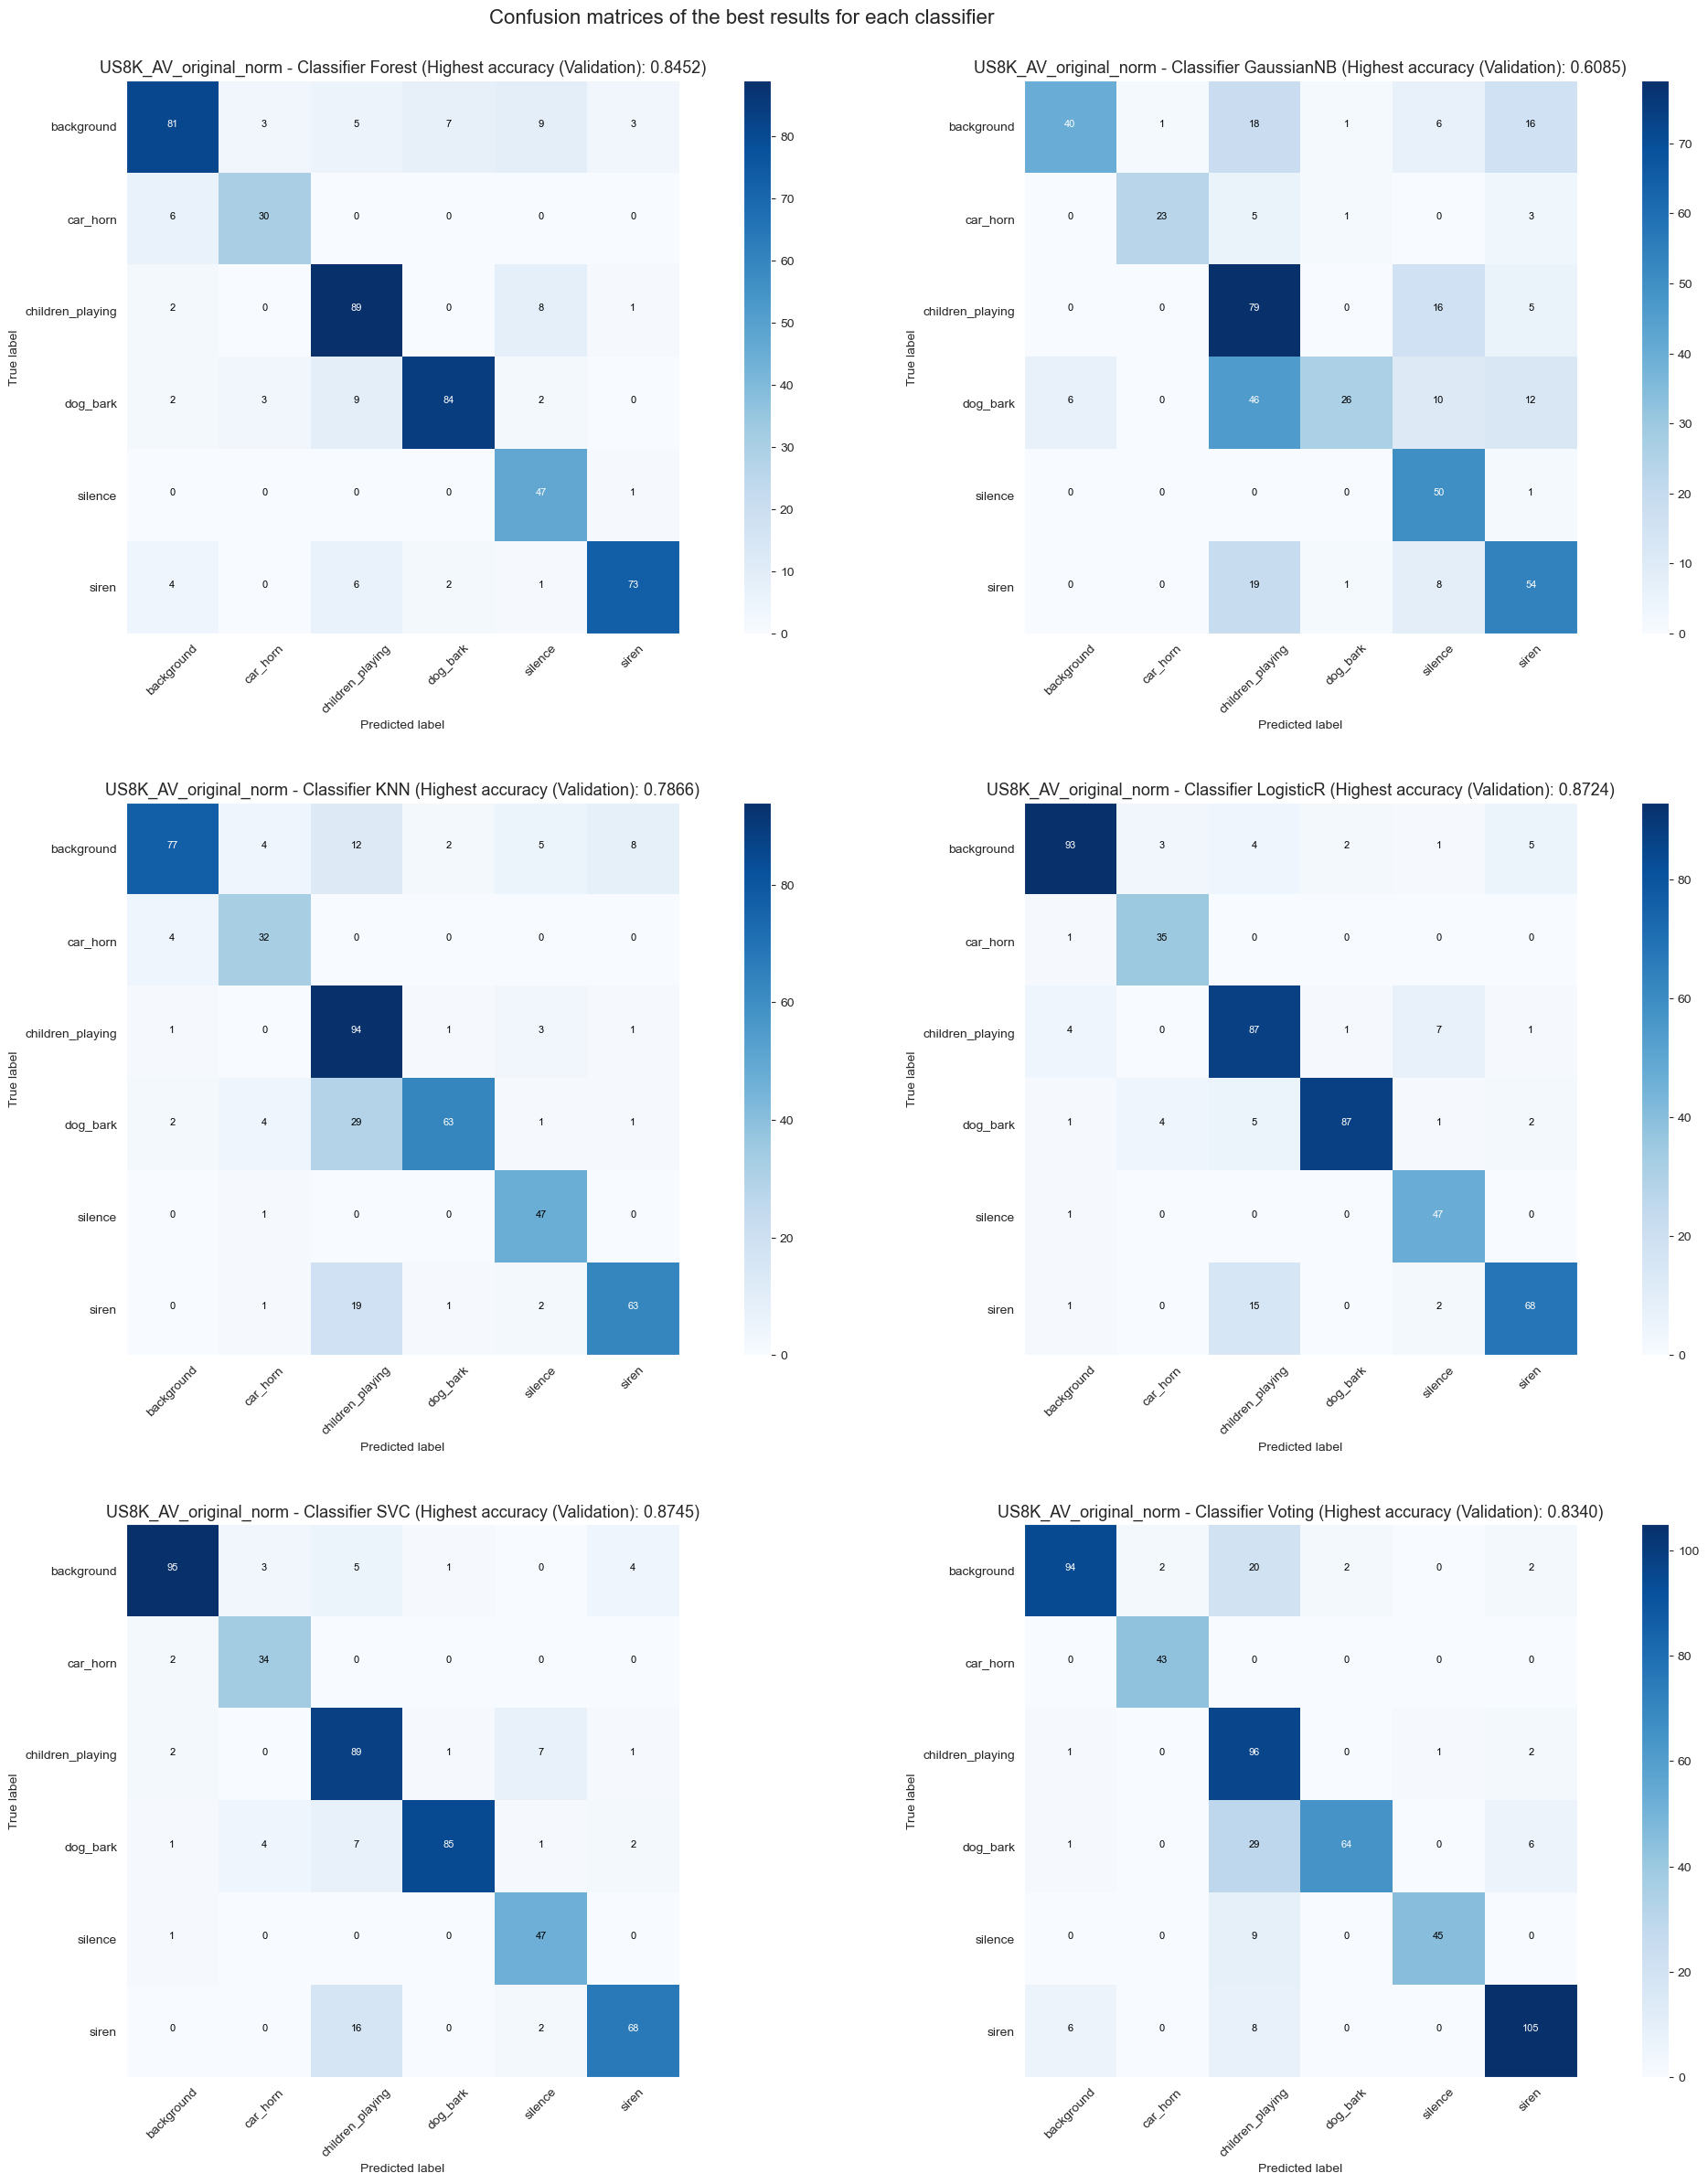

In [37]:
# Plot the confusion matrix for the highest accuracy test classifiers

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(25,25))
plt.suptitle('Confusion matrices of the best results for each classifier', fontsize = 16,  y=0.97)
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    title = nom_dataset + model_surname + batch_name + ' - Classifier '+ i + ' (Highest accuracy (Validation): ' + str("{:0.4f}".format(conf_matrices_dict[i]['Accuracy(Validation)'])) +')'
    plt.subplot(3,2,idx)
    plot_confusion_matrix(conf_matrices_dict[i]['Conf_M'],  
                          nom_classes, 
                          title,
                          cmap = None,                          
                          normalize = False)
plt.tight_layout(pad=4.0)
plt.savefig(os.path.join(path_pic, picture_name))

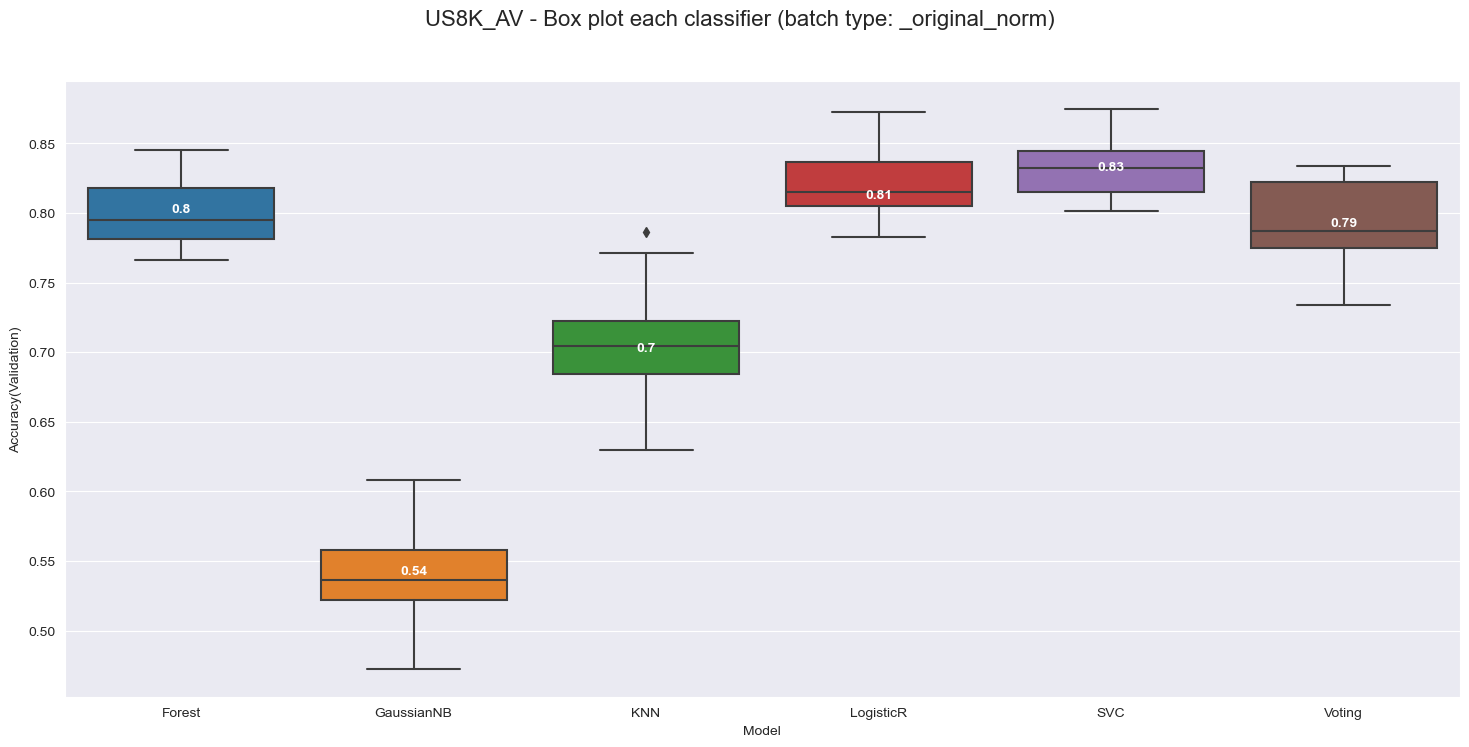

In [38]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(18,8))
plt.suptitle(f'{nom_dataset} - Box plot each classifier (batch type: {model_surname + batch_name})', fontsize = 16,  y=0.97)
box_plot = sns.boxplot(data=metrics_set, x="Model", y="Accuracy(Validation)", showfliers = True)

medians = list(metrics_set.groupby(['Model'], sort = False)['Accuracy(Validation)'].median())
medians = [round(element, 2) for element in medians]

vertical_offset = metrics_set['Accuracy(Validation)'].median()*0.001  # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
plt.savefig(os.path.join(path_pic, picture_name))

## Results ESC-10 (including the NN results) - Compiled in Excel

Original x Augmented

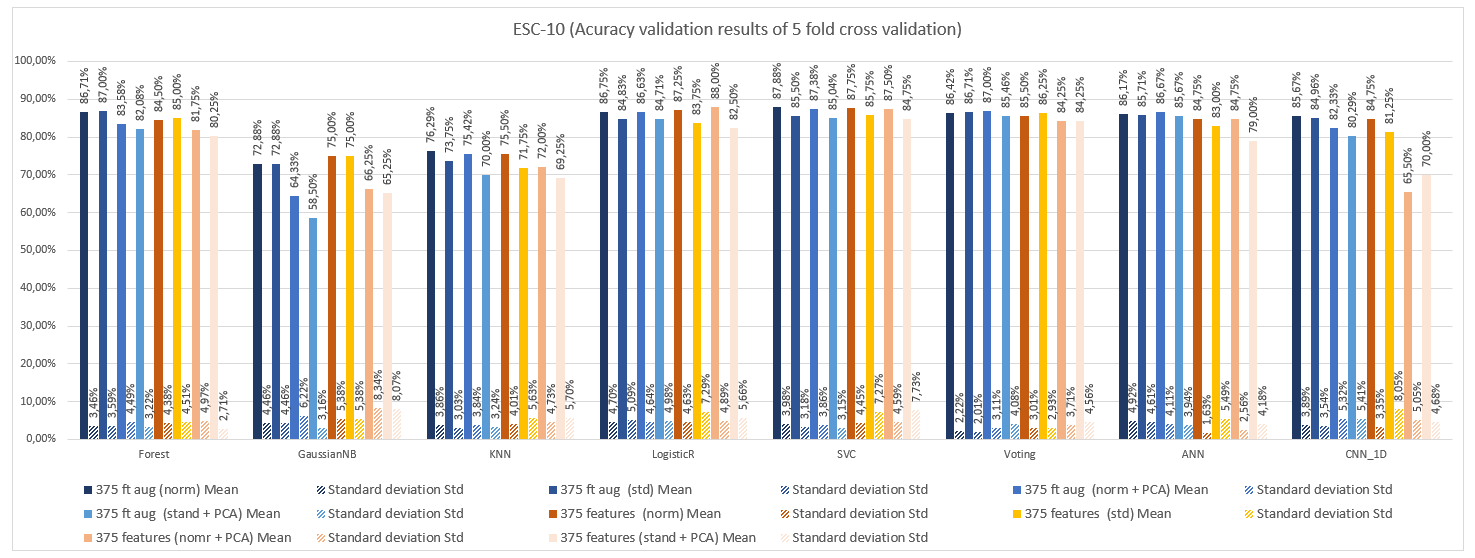

Augmented x Windowed

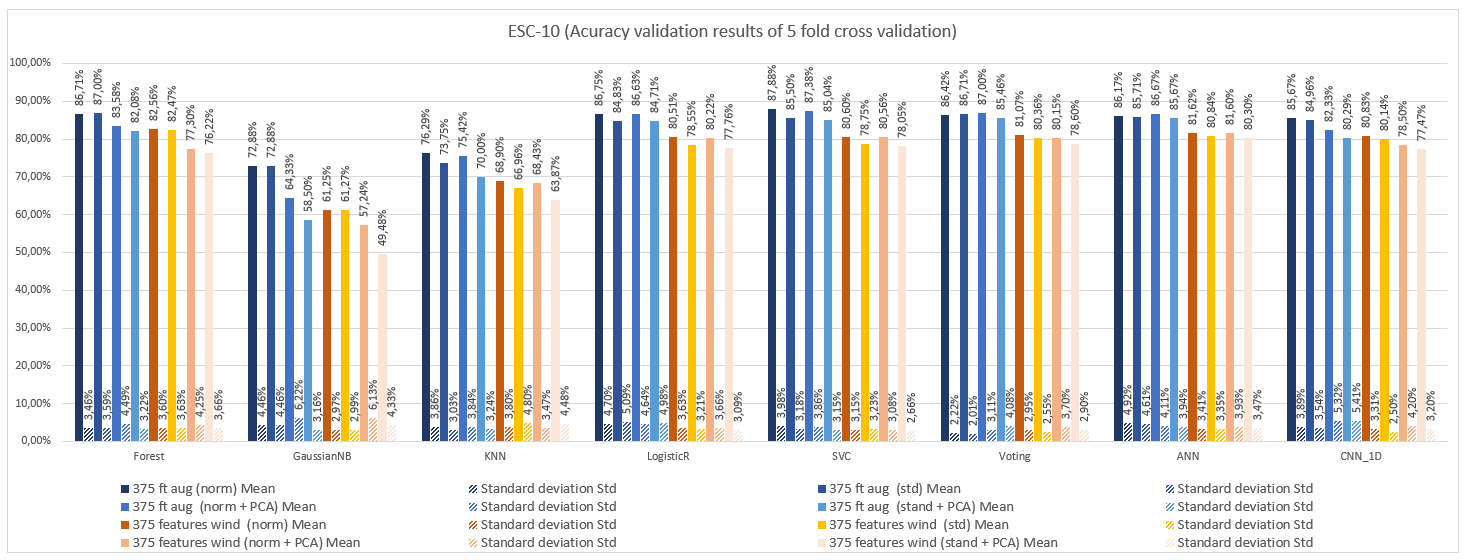

## Results BDLib2 (including the NN results) - Compiled in Excel

Original x Augmented

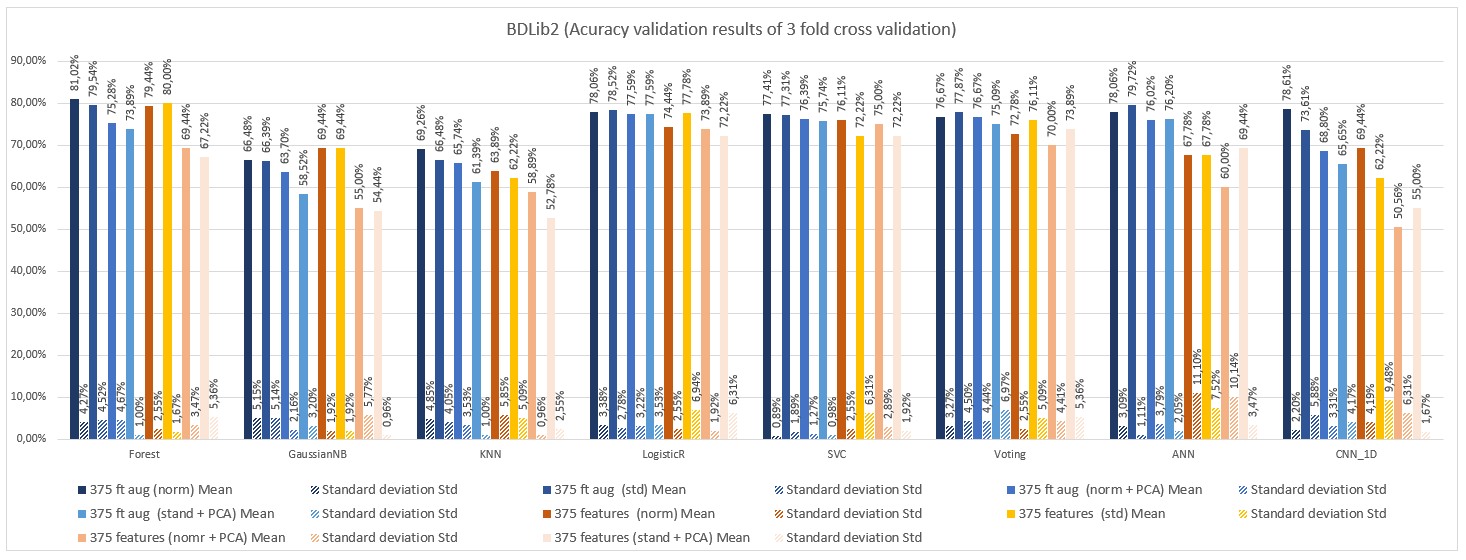

Augmented x Windowed

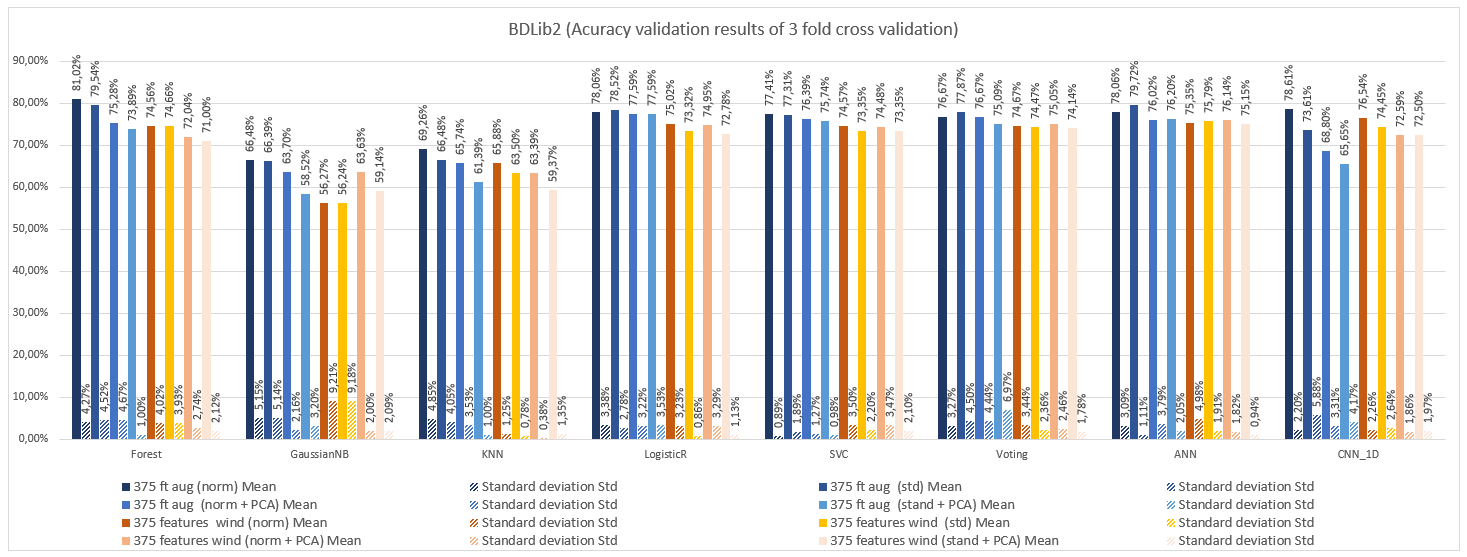

## Results US8K (including the NN results) - Compiled in Excel

Original x Augmented

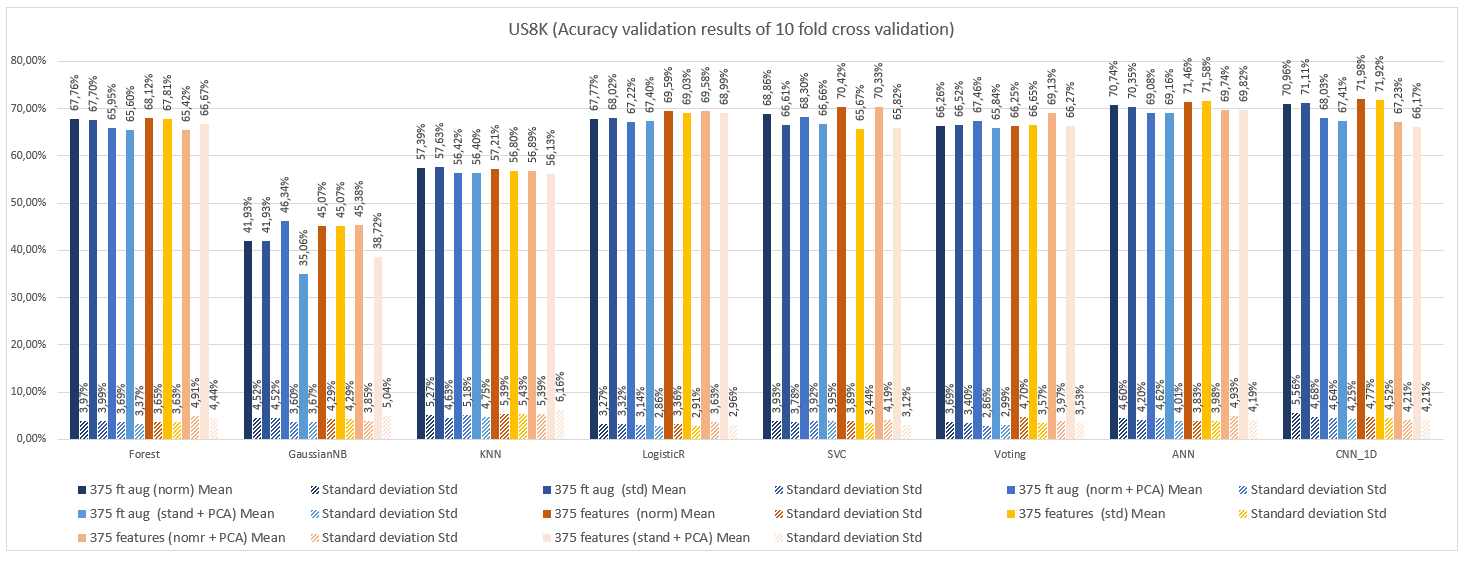

Augmented x Windowed

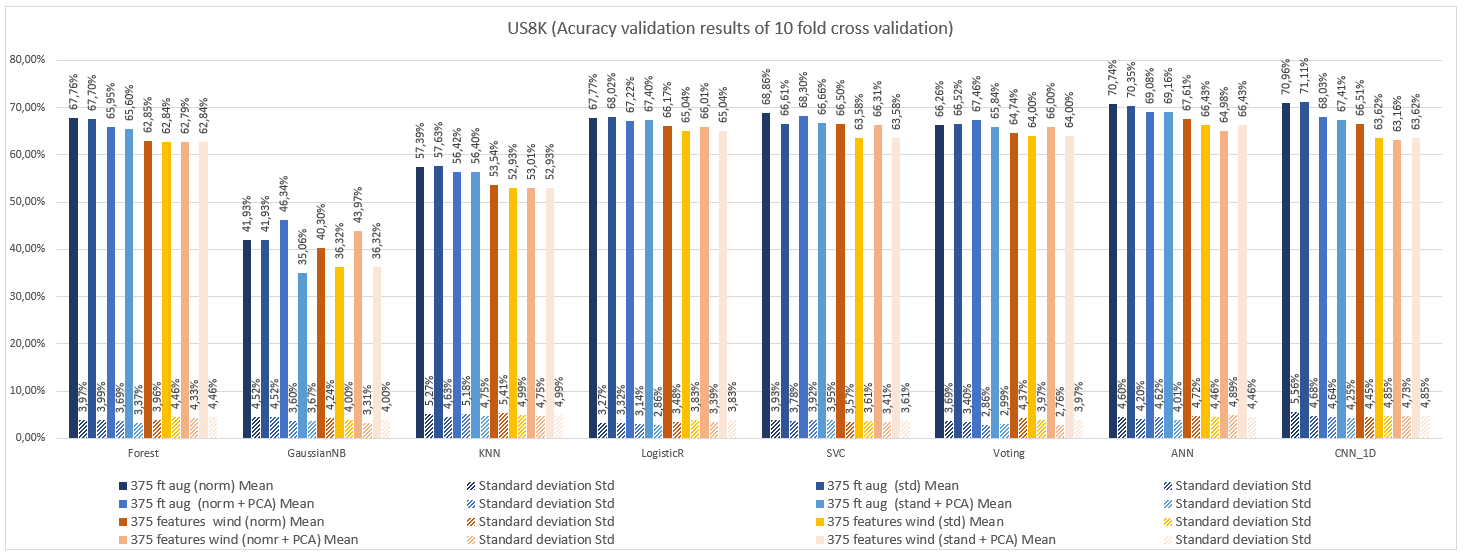

## Results US8K_AV (including the NN results) - Compiled in Excel

Original x Augmented

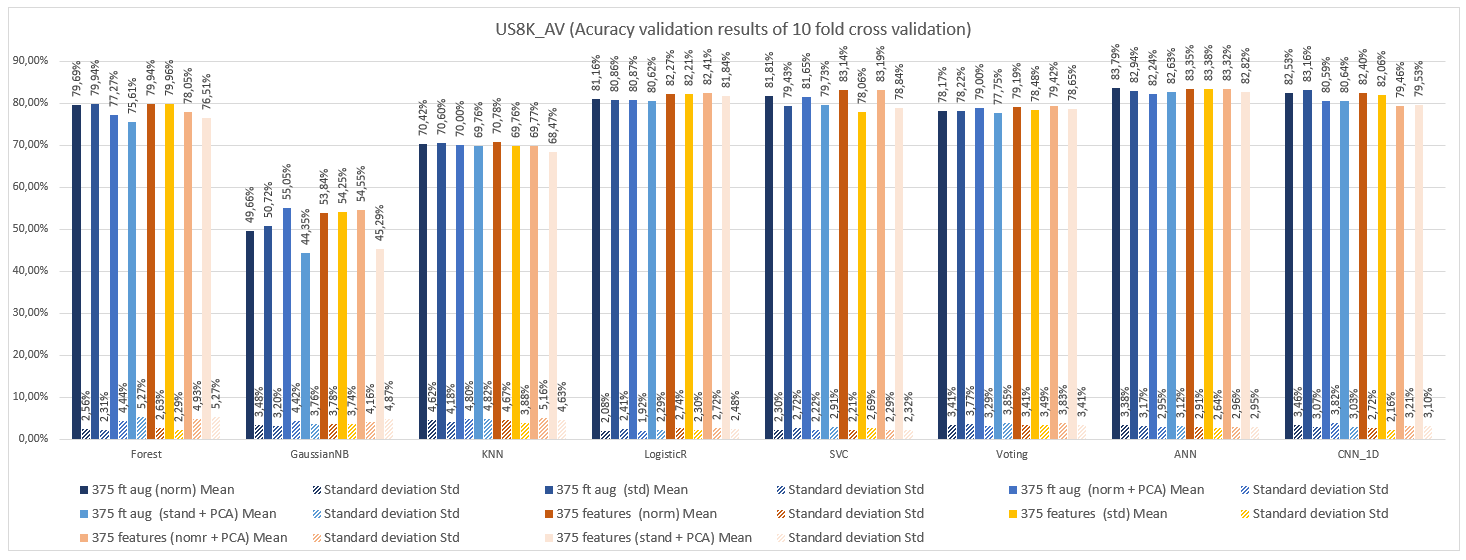

Augmented x Windowed

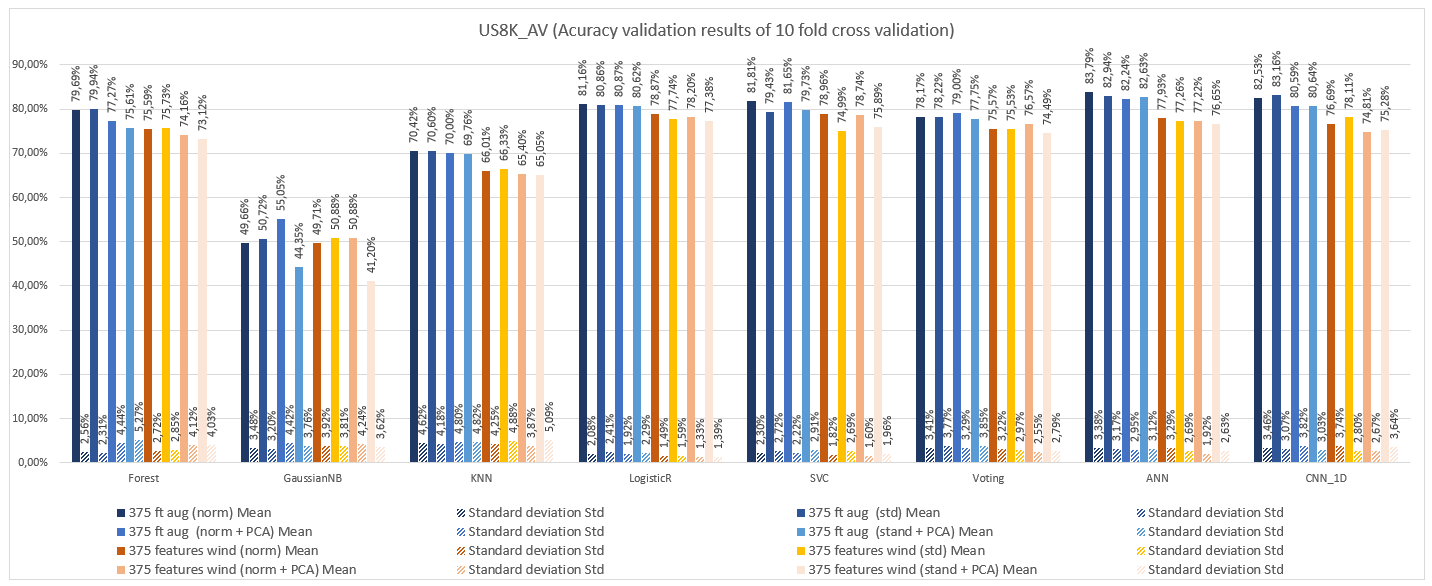

# End of notebook